In [1]:
import os
import torch
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick

import numpy as np
import pandas as pd
import seaborn as sns
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset

from tqdm import trange
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.manifold import TSNE
from sklearn.utils import shuffle

In [30]:
class CNN1D(nn.Module):
    def __init__(self, number_of_categories):
        super(CNN1D, self).__init__()
        # convolution layer
        # in_channels must be the same as the number of subcarriers, out_channels can be any value
        self.conv1d = nn.Conv1d(in_channels=1, out_channels=64, kernel_size=3, stride=1)
        self.conv1d_2 = nn.Conv1d(in_channels=64, out_channels=128, kernel_size=5, stride=1)
        self.conv1d_3 = nn.Conv1d(in_channels=128, out_channels=256, kernel_size=3, stride=1)
        self.maxpool = nn.MaxPool1d(kernel_size=2)
        self.relu = nn.ReLU()
        self.batch_norm = nn.BatchNorm1d(64)
        self.batch_norm_2 = nn.BatchNorm1d(128)
        self.batch_norm_3 = nn.BatchNorm1d(256)
        self.dropout = nn.Dropout1d(p=0.5)
        

        # calculate the in_features
        self.fc1 = nn.Linear(in_features=512, out_features=128)
        self.fc2 = nn.Linear(in_features=128, out_features=number_of_categories)

    def forward(self, x):
        # input tensor size [batch_size, 64 (features), 40 (sequence length)]
        x = self.conv1d(x)
        # # [batch_size, 64 (features), 40 (sequence length)]
        x = self.batch_norm(x)
        x = self.relu(x)
        x = self.dropout(x)
        x = self.maxpool(x)
        
        x = self.conv1d_2(x)
        # # [batch_size, 64 (features), 40 (sequence length)]
        x = self.batch_norm_2(x)
        x = self.relu(x)
        x = self.dropout(x)
        x = self.maxpool(x)
        
        x = self.conv1d_3(x)
        # # [batch_size, 64 (features), 40 (sequence length)]
        x = self.batch_norm_3(x)
        x = self.relu(x)
        x = self.dropout(x)
        x = self.maxpool(x)
        
        x = x.view(-1, x.shape[1] * x.shape[2])  # Adjust the input size based on the output size after convolutions and pooling\
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)

        return x

In [18]:
# test = np.random.rand(40, )
# x = torch.tensor(test, dtype=torch.float32)
# print(test.shape)
#test = x.unsqueeze(0)
#print(test)
testing = np.random.rand(64, 1, 40 )
new = np.random.rand(1, 40)
print(new)
x = torch.tensor(testing, dtype=torch.float32)
conv1d = nn.Conv1d(in_channels=1, out_channels=64, kernel_size=3, stride=1)
conv1d_2 = nn.Conv1d(in_channels=64, out_channels=128, kernel_size=5, stride=1)
conv1d_3 = nn.Conv1d(in_channels=128, out_channels=256, kernel_size=3, stride=1)
maxpool = nn.MaxPool1d(kernel_size=2)
dropout = nn.Dropout1d(p=0.5)
flatten = nn.Flatten(0)

relu = nn.ReLU()

# calculate the in_features
fc1 = nn.Linear(in_features=256, out_features=128)
# self.fc1 = nn.Linear(in_features=120, out_features=90)
fc2 = nn.Linear(in_features=128, out_features=10)

x = conv1d(x)
# [batch_size, 64 (features), 40 (sequence length)]
x = relu(x)
x = maxpool(x)
print(x.shape)
x = dropout(x)
x = conv1d_2(x)
# [batch_size, 64 (features), 40 (sequence length)]
x = relu(x)
x = maxpool(x)
print(x.shape)
x = dropout(x)
x = conv1d_3(x)
# [batch_size, 64 (features), 40 (sequence length)]
x = relu(x)
x = maxpool(x)
print(x.shape)
x = dropout(x)
x = x.view(-1, x.shape[1] * x.shape[2])  # Adjust the input size based on the output size after convolutions and pooling

print(x.shape)
x = fc1(x)
x = relu(x)
x = fc2(x)

[[0.89791616 0.19238013 0.62945046 0.86316389 0.01735072 0.25639148
  0.85197991 0.38931035 0.85861953 0.10493076 0.90891688 0.06074454
  0.72074641 0.26971217 0.46406514 0.93878079 0.72143353 0.02834914
  0.257736   0.95571597 0.20237624 0.99459999 0.022132   0.34177808
  0.72220885 0.98121747 0.9110368  0.91813289 0.34714199 0.58935928
  0.72662105 0.58097726 0.56131705 0.16763715 0.57973246 0.16043128
  0.2421254  0.61613146 0.42858433 0.91020351]]
torch.Size([64, 64, 19])
torch.Size([64, 128, 7])
torch.Size([64, 256, 2])
torch.Size([64, 512])


RuntimeError: mat1 and mat2 shapes cannot be multiplied (64x512 and 256x128)

In [4]:
class CSIDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.tensor(X, dtype=torch.float32)
        self.y = torch.tensor(y, dtype=torch.int)
    
    def __len__(self):
        return len(self.X)
    
    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

In [5]:
def importData():
    X_train, X_val, X_test, y_train, y_val, y_test = [], [], [], [], [], []
    for i in range(10):
        temp_train = np.load(f'../data/process_data/{i}_table_train.npy')
        temp_val = np.load(f'../data/process_data/{i}_table_val.npy')
        temp_test = np.load(f'../data/process_data/{i}_table_test.npy')
        if i == 0:
            X_train = temp_train
            X_val = temp_val
            X_test = temp_test
            y_train = np.array([[i] for _ in range(X_train.shape[0])])
            y_val = np.array([[i] for _ in range(X_val.shape[0])])
            y_test = np.array([[i] for _ in range(X_test.shape[0])])
        else:
            X_train = np.append(X_train, temp_train, axis=0)
            X_val = np.append(X_val, temp_val, axis=0)
            X_test = np.append(X_test, temp_test, axis=0)
            y_train = np.append(y_train, np.array([[i] for _ in range(temp_train.shape[0])]), axis=0)
            y_val = np.append(y_val, np.array([[i] for _ in range(temp_val.shape[0])]), axis=0)
            y_test = np.append(y_test, np.array([[i] for _ in range(temp_test.shape[0])]), axis=0)
            
    return X_train, X_val, X_test, y_train, y_val, y_test

In [6]:
class RunningAverage:
    def __init__(self):
        self.steps = 0
        self.total = 0

    def update(self, val):
        self.total += val
        self.steps += 1

    def __call__(self):
        return self.total / float(self.steps)

def accuracy(outputs, labels):
    # outputs (predicted), labels (true)
    outputs = np.argmax(outputs.cpu().detach().numpy(), axis=1)
    labels = labels.squeeze()
    # compare outputs with labels
    return np.sum([1 if first == second else 0 for first, second in zip(labels, outputs)]) / float(len(labels))

In [7]:
def train(model, optimizer, trainLoader, loss_fn, iterations):
    model.train()
    train_loss = RunningAverage()
    train_acc = RunningAverage()
    
    with trange(iterations) as pbar:
        for X_batch, y_batch in trainLoader:
            y_batch = y_batch.type(torch.LongTensor).squeeze(1)
            logits = model(X_batch)
            y_pred = F.log_softmax(logits, dim=1) # use this for accuracy 
            loss = loss_fn(logits, y_batch)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            train_loss.update(loss)
            train_acc.update(accuracy(y_pred, y_batch))
            pbar.update(1)
            
    return train_loss(), train_acc()
    
def eval(model, valLoader, loss_fn):
    model.eval()
    eval_loss = RunningAverage()
    eval_acc = RunningAverage()
    
    with torch.no_grad():
        for X_batch, y_batch in valLoader:
            y_batch = y_batch.type(torch.LongTensor).squeeze(1)
            logits = model(X_batch)
            y_pred = F.log_softmax(logits, dim=1) # use this for accuracy 
            loss = loss_fn(logits, y_batch)
            
            eval_loss.update(loss)
            eval_acc.update(accuracy(y_pred, y_batch))
            
    return eval_loss(), eval_acc()
    
def test(model, testLoader, test_size):
    model.eval()
    for X_batch, y_batch in testLoader:
        y_batch = y_batch.type(torch.LongTensor).squeeze(1)
        logits = model(X_batch)
        y_pred = F.log_softmax(logits, dim=1) # use this for accuracy 
        
    print(f"Overall Accuracy: {accuracy(y_pred, y_batch):.3f}")

    # True positive percentage
    percentages = {0: 0, 1: 0, 2: 0, 3: 0, 4: 0, 5: 0, 6: 0, 7: 0, 8: 0, 9: 0}
    # outputs (predicted), labels (true)
    outputs = np.argmax(y_pred.cpu().detach().numpy(), axis=1)
    labels = y_batch.squeeze()
    
    for i in range(len(outputs)):
        if outputs[i] == labels[i]:
            percentages[outputs[i]] += 1
    
    # plot the percentages of correct predictions
    y_percent = [(value/(test_size/10))*100 for key, value in percentages.items()]
    x_label = [str(key) for key, _ in percentages.items()]
    
    fig, test = plt.subplots(figsize=(10,6))
    test.bar(x_label, y_percent)
    test.yaxis.set_major_formatter(mtick.PercentFormatter())
    
    plt.ylabel("Accuracy (%)")
    plt.xlabel("Key")
    plt.title("Accuracy (%) per key")
    plt.savefig("percentage_correct_final.png", bbox_inches='tight')
    plt.show()
    
    cm = confusion_matrix(y_true=labels, y_pred=outputs)
    cm = np.divide(cm, (test_size/10))
    
    plt.figure(figsize=(10,6))
    sns.heatmap(cm, annot=True, fmt='.2%', cmap='Blues')
    plt.ylabel("True Label")
    plt.xlabel("Predicted Label")
    plt.savefig("confusion_matrix_final.png", bbox_inches='tight')
    plt.show()
    
    print(f"Accuracy for each key: {''.join([x + ': ' + str(round(y, 3)) + '% ' for x, y in zip(x_label, y_percent)])}")
    
    print(classification_report(y_true=labels, y_pred=outputs, target_names=x_label))

In [8]:
def train_and_eval(model, epochs, optimizer, trainLoader, valLoader, loss_fn, iterations):
    # for plotting the loss and accuracy
    train_loss_list, train_acc_list, eval_loss_list, eval_acc_list  = [], [], [], []
        
    for epoch in range(epochs):
        train_loss, train_acc = train(model, optimizer, trainLoader, loss_fn, iterations)
        eval_loss, eval_acc = eval(model, valLoader, loss_fn)
        
        train_loss_list.append(train_loss)
        train_acc_list.append(train_acc)
        eval_loss_list.append(eval_loss)
        eval_acc_list.append(eval_acc)
        
        print(f"Train: Epoch {epoch}: Loss {train_loss}, Accuracy {train_acc}")
        print(f"Eval: Epoch {epoch}: Loss {eval_loss}, Accuracy {eval_acc}")
        
    return train_loss_list, train_acc_list, eval_loss_list, eval_acc_list
        

In [9]:
def plot_loss_accuracy(train_loss_list, train_acc_list, eval_loss_list, eval_acc_list, epochs):
    x = [i for i in range(1, epochs+1)]
    
    fig, loss = plt.subplots(figsize=(10,6))
    loss.plot(x, [trainLoss.item() for trainLoss in train_loss_list], label="Training Loss")
    loss.plot(x, [evalLoss.item() for evalLoss in eval_loss_list], label="Validation Loss")
    plt.legend()
    plt.ylabel("Average Loss")
    plt.xlabel("Epochs")
    plt.title("Average Loss per epoch")
    plt.savefig("loss_per_epoch_final.png", bbox_inches='tight')
    
    plt.show()
    
    fig, acc = plt.subplots(figsize=(10,6))
    acc.plot(x, [trainAcc.item() for trainAcc in train_acc_list], label="Training Accuracy")
    acc.plot(x, [evalAcc.item() for evalAcc in eval_acc_list], label="Validation Accuracy")
    plt.legend()
    plt.ylabel("Average Accuracy")
    plt.xlabel("Epochs")
    plt.title("Average Accuracy per epoch")
    plt.savefig("acc_per_epoch_final.png", bbox_inches='tight')
    plt.show()

In [10]:
def print_model_parameters(model):
    total_parameters = 0
    print(" "*20 + "Model Parameters" + " "*20)
    print("="*57)
    print(f"{'Layer':<25}" + "| Parameters")
    print("="*57)
    for name, param in model.named_parameters():
        temp = 1
        temp_list = []
        if param.requires_grad:
            print(f"{name:<25}", end="")
            for i in param.data.shape:
                temp *= i
                temp_list.append(str(i))
            print(": ", end="")
            if len(temp_list) > 1:
                print(f"{' * '.join(temp_list)}", end="")
                print(" = " + str(temp))
            else:
                print(f"{''.join(temp_list)}")

        total_parameters += temp
        
    print("="*57)
    print(f"{'Total parameters':<25}" + f": {total_parameters}")
    print("="*57)

100%|██████████| 55/55 [00:01<00:00, 40.29it/s]


Train: Epoch 0: Loss 2.3260059356689453, Accuracy 0.10105888429752066
Eval: Epoch 0: Loss 2.3054497241973877, Accuracy 0.106640625


100%|██████████| 55/55 [00:01<00:00, 46.34it/s]


Train: Epoch 1: Loss 2.316178798675537, Accuracy 0.10490702479338843
Eval: Epoch 1: Loss 2.3052730560302734, Accuracy 0.1052734375


100%|██████████| 55/55 [00:01<00:00, 49.91it/s]


Train: Epoch 2: Loss 2.3142144680023193, Accuracy 0.10604338842975206
Eval: Epoch 2: Loss 2.3059241771698, Accuracy 0.1033203125


100%|██████████| 55/55 [00:01<00:00, 51.02it/s]


Train: Epoch 3: Loss 2.3166344165802, Accuracy 0.09922520661157024
Eval: Epoch 3: Loss 2.3061904907226562, Accuracy 0.1046875


100%|██████████| 55/55 [00:01<00:00, 50.14it/s]


Train: Epoch 4: Loss 2.314084768295288, Accuracy 0.09806301652892561
Eval: Epoch 4: Loss 2.3057475090026855, Accuracy 0.0951171875


100%|██████████| 55/55 [00:01<00:00, 48.37it/s]


Train: Epoch 5: Loss 2.3141510486602783, Accuracy 0.1021952479338843
Eval: Epoch 5: Loss 2.305814266204834, Accuracy 0.1052734375


100%|██████████| 55/55 [00:01<00:00, 49.82it/s]


Train: Epoch 6: Loss 2.311850070953369, Accuracy 0.09979338842975206
Eval: Epoch 6: Loss 2.3061363697052, Accuracy 0.1001953125


100%|██████████| 55/55 [00:02<00:00, 23.37it/s]


Train: Epoch 7: Loss 2.3097150325775146, Accuracy 0.1081611570247934
Eval: Epoch 7: Loss 2.3055622577667236, Accuracy 0.101953125


100%|██████████| 55/55 [00:01<00:00, 41.35it/s]


Train: Epoch 8: Loss 2.309438705444336, Accuracy 0.10606921487603306
Eval: Epoch 8: Loss 2.304774284362793, Accuracy 0.1091796875


100%|██████████| 55/55 [00:01<00:00, 50.60it/s]


Train: Epoch 9: Loss 2.308347225189209, Accuracy 0.10521694214876033
Eval: Epoch 9: Loss 2.3050332069396973, Accuracy 0.1025390625


100%|██████████| 55/55 [00:01<00:00, 48.50it/s]


Train: Epoch 10: Loss 2.3080151081085205, Accuracy 0.10175619834710745
Eval: Epoch 10: Loss 2.3045172691345215, Accuracy 0.106640625


100%|██████████| 55/55 [00:01<00:00, 48.37it/s]


Train: Epoch 11: Loss 2.3118526935577393, Accuracy 0.09059917355371902
Eval: Epoch 11: Loss 2.304226875305176, Accuracy 0.0951171875


100%|██████████| 55/55 [00:01<00:00, 49.68it/s]


Train: Epoch 12: Loss 2.308310031890869, Accuracy 0.11149276859504131
Eval: Epoch 12: Loss 2.3044724464416504, Accuracy 0.109765625


100%|██████████| 55/55 [00:01<00:00, 51.40it/s]


Train: Epoch 13: Loss 2.3060462474823, Accuracy 0.09878615702479339
Eval: Epoch 13: Loss 2.3037965297698975, Accuracy 0.108984375


100%|██████████| 55/55 [00:01<00:00, 51.12it/s]


Train: Epoch 14: Loss 2.3078274726867676, Accuracy 0.10506198347107439
Eval: Epoch 14: Loss 2.3043065071105957, Accuracy 0.1060546875


100%|██████████| 55/55 [00:01<00:00, 49.06it/s]


Train: Epoch 15: Loss 2.3038980960845947, Accuracy 0.11061466942148761
Eval: Epoch 15: Loss 2.3040781021118164, Accuracy 0.108203125


100%|██████████| 55/55 [00:01<00:00, 48.50it/s]


Train: Epoch 16: Loss 2.3071231842041016, Accuracy 0.11002066115702479
Eval: Epoch 16: Loss 2.3048627376556396, Accuracy 0.0966796875


100%|██████████| 55/55 [00:01<00:00, 50.18it/s]


Train: Epoch 17: Loss 2.3033766746520996, Accuracy 0.12024793388429751
Eval: Epoch 17: Loss 2.3050484657287598, Accuracy 0.0931640625


100%|██████████| 55/55 [00:01<00:00, 49.91it/s]


Train: Epoch 18: Loss 2.303058624267578, Accuracy 0.10454545454545454
Eval: Epoch 18: Loss 2.3054099082946777, Accuracy 0.089453125


100%|██████████| 55/55 [00:01<00:00, 49.95it/s]


Train: Epoch 19: Loss 2.3025753498077393, Accuracy 0.1071797520661157
Eval: Epoch 19: Loss 2.305382251739502, Accuracy 0.0890625


100%|██████████| 55/55 [00:01<00:00, 50.00it/s]


Train: Epoch 20: Loss 2.3020236492156982, Accuracy 0.11373966942148761
Eval: Epoch 20: Loss 2.305283784866333, Accuracy 0.094140625


100%|██████████| 55/55 [00:01<00:00, 49.59it/s]


Train: Epoch 21: Loss 2.3050589561462402, Accuracy 0.11203512396694215
Eval: Epoch 21: Loss 2.305302858352661, Accuracy 0.08828125


100%|██████████| 55/55 [00:01<00:00, 50.32it/s]


Train: Epoch 22: Loss 2.304901361465454, Accuracy 0.1009297520661157
Eval: Epoch 22: Loss 2.3052711486816406, Accuracy 0.0904296875


100%|██████████| 55/55 [00:01<00:00, 49.15it/s]


Train: Epoch 23: Loss 2.3044402599334717, Accuracy 0.10774793388429751
Eval: Epoch 23: Loss 2.30586314201355, Accuracy 0.081640625


100%|██████████| 55/55 [00:01<00:00, 45.79it/s]


Train: Epoch 24: Loss 2.302692174911499, Accuracy 0.1103305785123967
Eval: Epoch 24: Loss 2.3055570125579834, Accuracy 0.08125


100%|██████████| 55/55 [00:01<00:00, 46.97it/s]


Train: Epoch 25: Loss 2.3000094890594482, Accuracy 0.11632231404958678
Eval: Epoch 25: Loss 2.3063063621520996, Accuracy 0.0818359375


100%|██████████| 55/55 [00:01<00:00, 50.37it/s]


Train: Epoch 26: Loss 2.3035950660705566, Accuracy 0.10759297520661158
Eval: Epoch 26: Loss 2.3054795265197754, Accuracy 0.08828125


100%|██████████| 55/55 [00:01<00:00, 50.09it/s]


Train: Epoch 27: Loss 2.3017871379852295, Accuracy 0.1137138429752066
Eval: Epoch 27: Loss 2.3055613040924072, Accuracy 0.0927734375


100%|██████████| 55/55 [00:01<00:00, 47.83it/s]


Train: Epoch 28: Loss 2.304041862487793, Accuracy 0.11229338842975206
Eval: Epoch 28: Loss 2.305504083633423, Accuracy 0.093359375


100%|██████████| 55/55 [00:01<00:00, 49.77it/s]


Train: Epoch 29: Loss 2.2999985218048096, Accuracy 0.1137138429752066
Eval: Epoch 29: Loss 2.305536985397339, Accuracy 0.0912109375


100%|██████████| 55/55 [00:01<00:00, 50.60it/s]


Train: Epoch 30: Loss 2.3006715774536133, Accuracy 0.1146952479338843
Eval: Epoch 30: Loss 2.306187152862549, Accuracy 0.08671875


100%|██████████| 55/55 [00:01<00:00, 48.72it/s]


Train: Epoch 31: Loss 2.2992043495178223, Accuracy 0.11314566115702479
Eval: Epoch 31: Loss 2.3060555458068848, Accuracy 0.087890625


100%|██████████| 55/55 [00:01<00:00, 49.86it/s]


Train: Epoch 32: Loss 2.302353620529175, Accuracy 0.10632747933884297
Eval: Epoch 32: Loss 2.305839776992798, Accuracy 0.0828125


100%|██████████| 55/55 [00:01<00:00, 50.46it/s]


Train: Epoch 33: Loss 2.3009393215179443, Accuracy 0.1121642561983471
Eval: Epoch 33: Loss 2.3056275844573975, Accuracy 0.0837890625


100%|██████████| 55/55 [00:01<00:00, 50.83it/s]


Train: Epoch 34: Loss 2.299116611480713, Accuracy 0.11084710743801653
Eval: Epoch 34: Loss 2.3059279918670654, Accuracy 0.0841796875


100%|██████████| 55/55 [00:01<00:00, 49.19it/s]


Train: Epoch 35: Loss 2.2985894680023193, Accuracy 0.11637396694214876
Eval: Epoch 35: Loss 2.3067076206207275, Accuracy 0.0845703125


100%|██████████| 55/55 [00:01<00:00, 50.18it/s]


Train: Epoch 36: Loss 2.299182415008545, Accuracy 0.11554752066115703
Eval: Epoch 36: Loss 2.3069705963134766, Accuracy 0.087109375


100%|██████████| 55/55 [00:01<00:00, 49.24it/s]


Train: Epoch 37: Loss 2.2989864349365234, Accuracy 0.11642561983471074
Eval: Epoch 37: Loss 2.3068690299987793, Accuracy 0.0900390625


100%|██████████| 55/55 [00:01<00:00, 50.51it/s]


Train: Epoch 38: Loss 2.2988498210906982, Accuracy 0.11497933884297522
Eval: Epoch 38: Loss 2.3064281940460205, Accuracy 0.094140625


100%|██████████| 55/55 [00:01<00:00, 49.06it/s]


Train: Epoch 39: Loss 2.300077199935913, Accuracy 0.1165547520661157
Eval: Epoch 39: Loss 2.3067586421966553, Accuracy 0.091796875


100%|██████████| 55/55 [00:01<00:00, 50.97it/s]


Train: Epoch 40: Loss 2.2993323802948, Accuracy 0.11301652892561984
Eval: Epoch 40: Loss 2.3074495792388916, Accuracy 0.090625


100%|██████████| 55/55 [00:01<00:00, 49.68it/s]


Train: Epoch 41: Loss 2.299330711364746, Accuracy 0.1131198347107438
Eval: Epoch 41: Loss 2.3082938194274902, Accuracy 0.08984375


100%|██████████| 55/55 [00:01<00:00, 49.59it/s]


Train: Epoch 42: Loss 2.2980196475982666, Accuracy 0.11384297520661157
Eval: Epoch 42: Loss 2.3084821701049805, Accuracy 0.0923828125


100%|██████████| 55/55 [00:01<00:00, 50.37it/s]


Train: Epoch 43: Loss 2.2960989475250244, Accuracy 0.12252066115702478
Eval: Epoch 43: Loss 2.308793783187866, Accuracy 0.0849609375


100%|██████████| 55/55 [00:01<00:00, 50.64it/s]


Train: Epoch 44: Loss 2.2977826595306396, Accuracy 0.11825929752066115
Eval: Epoch 44: Loss 2.309095859527588, Accuracy 0.0904296875


100%|██████████| 55/55 [00:01<00:00, 50.64it/s]


Train: Epoch 45: Loss 2.2959718704223633, Accuracy 0.11996384297520661
Eval: Epoch 45: Loss 2.3087658882141113, Accuracy 0.0970703125


100%|██████████| 55/55 [00:01<00:00, 49.42it/s]


Train: Epoch 46: Loss 2.298898220062256, Accuracy 0.11596074380165289
Eval: Epoch 46: Loss 2.3097593784332275, Accuracy 0.094921875


100%|██████████| 55/55 [00:01<00:00, 50.00it/s]


Train: Epoch 47: Loss 2.296389579772949, Accuracy 0.12363119834710744
Eval: Epoch 47: Loss 2.3101820945739746, Accuracy 0.1


100%|██████████| 55/55 [00:01<00:00, 49.86it/s]


Train: Epoch 48: Loss 2.2961905002593994, Accuracy 0.1253873966942149
Eval: Epoch 48: Loss 2.3101792335510254, Accuracy 0.0939453125


100%|██████████| 55/55 [00:01<00:00, 51.07it/s]


Train: Epoch 49: Loss 2.2980782985687256, Accuracy 0.12396694214876033
Eval: Epoch 49: Loss 2.3100221157073975, Accuracy 0.0974609375


100%|██████████| 55/55 [00:01<00:00, 49.37it/s]


Train: Epoch 50: Loss 2.2932982444763184, Accuracy 0.1193698347107438
Eval: Epoch 50: Loss 2.3091750144958496, Accuracy 0.098828125


100%|██████████| 55/55 [00:01<00:00, 50.74it/s]


Train: Epoch 51: Loss 2.295471668243408, Accuracy 0.12128099173553719
Eval: Epoch 51: Loss 2.3102855682373047, Accuracy 0.10546875


100%|██████████| 55/55 [00:01<00:00, 48.88it/s]


Train: Epoch 52: Loss 2.296090602874756, Accuracy 0.11949896694214876
Eval: Epoch 52: Loss 2.309924840927124, Accuracy 0.096875


100%|██████████| 55/55 [00:01<00:00, 49.06it/s]


Train: Epoch 53: Loss 2.2935593128204346, Accuracy 0.12192665289256198
Eval: Epoch 53: Loss 2.3102915287017822, Accuracy 0.0984375


100%|██████████| 55/55 [00:01<00:00, 49.67it/s]


Train: Epoch 54: Loss 2.2977445125579834, Accuracy 0.1115702479338843
Eval: Epoch 54: Loss 2.3113298416137695, Accuracy 0.1009765625


100%|██████████| 55/55 [00:01<00:00, 49.51it/s]


Train: Epoch 55: Loss 2.29411244392395, Accuracy 0.13300619834710745
Eval: Epoch 55: Loss 2.3111448287963867, Accuracy 0.0958984375


100%|██████████| 55/55 [00:01<00:00, 50.14it/s]


Train: Epoch 56: Loss 2.2940125465393066, Accuracy 0.1241219008264463
Eval: Epoch 56: Loss 2.311671018600464, Accuracy 0.0939453125


100%|██████████| 55/55 [00:01<00:00, 47.24it/s]


Train: Epoch 57: Loss 2.291642427444458, Accuracy 0.1259297520661157
Eval: Epoch 57: Loss 2.311046600341797, Accuracy 0.096875


100%|██████████| 55/55 [00:01<00:00, 45.42it/s]


Train: Epoch 58: Loss 2.293513536453247, Accuracy 0.1277892561983471
Eval: Epoch 58: Loss 2.3108911514282227, Accuracy 0.0990234375


100%|██████████| 55/55 [00:01<00:00, 45.80it/s]


Train: Epoch 59: Loss 2.2951772212982178, Accuracy 0.11825929752066115
Eval: Epoch 59: Loss 2.3111085891723633, Accuracy 0.094140625


100%|██████████| 55/55 [00:01<00:00, 50.31it/s]


Train: Epoch 60: Loss 2.290574550628662, Accuracy 0.12665289256198348
Eval: Epoch 60: Loss 2.31270694732666, Accuracy 0.0955078125


100%|██████████| 55/55 [00:01<00:00, 49.67it/s]


Train: Epoch 61: Loss 2.2889926433563232, Accuracy 0.13799070247933884
Eval: Epoch 61: Loss 2.3119540214538574, Accuracy 0.0896484375


100%|██████████| 55/55 [00:01<00:00, 49.73it/s]


Train: Epoch 62: Loss 2.2933619022369385, Accuracy 0.11753615702479339
Eval: Epoch 62: Loss 2.312861204147339, Accuracy 0.0912109375


100%|██████████| 55/55 [00:01<00:00, 48.72it/s]


Train: Epoch 63: Loss 2.2929129600524902, Accuracy 0.12861570247933884
Eval: Epoch 63: Loss 2.313474178314209, Accuracy 0.087109375


100%|██████████| 55/55 [00:01<00:00, 49.37it/s]


Train: Epoch 64: Loss 2.2945139408111572, Accuracy 0.12254648760330579
Eval: Epoch 64: Loss 2.3130173683166504, Accuracy 0.097265625


100%|██████████| 55/55 [00:01<00:00, 49.73it/s]


Train: Epoch 65: Loss 2.297750473022461, Accuracy 0.11188016528925619
Eval: Epoch 65: Loss 2.3126513957977295, Accuracy 0.09375


100%|██████████| 55/55 [00:01<00:00, 50.32it/s]


Train: Epoch 66: Loss 2.2920711040496826, Accuracy 0.1268336776859504
Eval: Epoch 66: Loss 2.313807725906372, Accuracy 0.0931640625


100%|██████████| 55/55 [00:01<00:00, 50.51it/s]


Train: Epoch 67: Loss 2.2933735847473145, Accuracy 0.12352789256198347
Eval: Epoch 67: Loss 2.3146417140960693, Accuracy 0.0939453125


100%|██████████| 55/55 [00:01<00:00, 49.91it/s]


Train: Epoch 68: Loss 2.2914211750030518, Accuracy 0.12055785123966943
Eval: Epoch 68: Loss 2.31455659866333, Accuracy 0.0962890625


100%|██████████| 55/55 [00:01<00:00, 52.03it/s]


Train: Epoch 69: Loss 2.292853832244873, Accuracy 0.12549070247933886
Eval: Epoch 69: Loss 2.314409017562866, Accuracy 0.0955078125


100%|██████████| 55/55 [00:01<00:00, 49.28it/s]


Train: Epoch 70: Loss 2.2893054485321045, Accuracy 0.12786673553719008
Eval: Epoch 70: Loss 2.314013957977295, Accuracy 0.0935546875


100%|██████████| 55/55 [00:01<00:00, 48.88it/s]


Train: Epoch 71: Loss 2.286663770675659, Accuracy 0.13070764462809917
Eval: Epoch 71: Loss 2.315670967102051, Accuracy 0.09609375


100%|██████████| 55/55 [00:01<00:00, 49.27it/s]


Train: Epoch 72: Loss 2.290550947189331, Accuracy 0.12190082644628099
Eval: Epoch 72: Loss 2.3151772022247314, Accuracy 0.0916015625


100%|██████████| 55/55 [00:01<00:00, 48.72it/s]


Train: Epoch 73: Loss 2.289273977279663, Accuracy 0.12760847107438017
Eval: Epoch 73: Loss 2.3147687911987305, Accuracy 0.0974609375


100%|██████████| 55/55 [00:01<00:00, 50.97it/s]


Train: Epoch 74: Loss 2.286290168762207, Accuracy 0.1256198347107438
Eval: Epoch 74: Loss 2.316521406173706, Accuracy 0.0912109375


100%|██████████| 55/55 [00:01<00:00, 51.07it/s]


Train: Epoch 75: Loss 2.287230968475342, Accuracy 0.1275309917355372
Eval: Epoch 75: Loss 2.316472053527832, Accuracy 0.0931640625


100%|██████████| 55/55 [00:01<00:00, 47.36it/s]


Train: Epoch 76: Loss 2.2911319732666016, Accuracy 0.12239152892561983
Eval: Epoch 76: Loss 2.316481828689575, Accuracy 0.090234375


100%|██████████| 55/55 [00:01<00:00, 48.76it/s]


Train: Epoch 77: Loss 2.2890617847442627, Accuracy 0.12363119834710744
Eval: Epoch 77: Loss 2.3166208267211914, Accuracy 0.098828125


100%|██████████| 55/55 [00:01<00:00, 49.77it/s]


Train: Epoch 78: Loss 2.287222385406494, Accuracy 0.12789256198347107
Eval: Epoch 78: Loss 2.316580057144165, Accuracy 0.0984375


100%|██████████| 55/55 [00:01<00:00, 49.15it/s]


Train: Epoch 79: Loss 2.2844014167785645, Accuracy 0.13442665289256198
Eval: Epoch 79: Loss 2.317868709564209, Accuracy 0.0966796875


100%|██████████| 55/55 [00:01<00:00, 50.00it/s]


Train: Epoch 80: Loss 2.2862603664398193, Accuracy 0.14028925619834712
Eval: Epoch 80: Loss 2.3188681602478027, Accuracy 0.09375


100%|██████████| 55/55 [00:01<00:00, 50.27it/s]


Train: Epoch 81: Loss 2.283709764480591, Accuracy 0.13458161157024795
Eval: Epoch 81: Loss 2.3195641040802, Accuracy 0.0982421875


100%|██████████| 55/55 [00:01<00:00, 49.68it/s]


Train: Epoch 82: Loss 2.2851722240448, Accuracy 0.13285123966942147
Eval: Epoch 82: Loss 2.317580223083496, Accuracy 0.1009765625


100%|██████████| 55/55 [00:01<00:00, 49.63it/s]


Train: Epoch 83: Loss 2.287778615951538, Accuracy 0.12551652892561985
Eval: Epoch 83: Loss 2.31695294380188, Accuracy 0.1076171875


100%|██████████| 55/55 [00:01<00:00, 50.18it/s]


Train: Epoch 84: Loss 2.2873520851135254, Accuracy 0.12391528925619835
Eval: Epoch 84: Loss 2.3181114196777344, Accuracy 0.0998046875


100%|██████████| 55/55 [00:01<00:00, 49.10it/s]


Train: Epoch 85: Loss 2.2840075492858887, Accuracy 0.13269628099173553
Eval: Epoch 85: Loss 2.317863702774048, Accuracy 0.1037109375


100%|██████████| 55/55 [00:01<00:00, 50.32it/s]


Train: Epoch 86: Loss 2.285964012145996, Accuracy 0.13711260330578512
Eval: Epoch 86: Loss 2.320352077484131, Accuracy 0.096484375


100%|██████████| 55/55 [00:01<00:00, 50.88it/s]


Train: Epoch 87: Loss 2.280738353729248, Accuracy 0.134323347107438
Eval: Epoch 87: Loss 2.319253444671631, Accuracy 0.1021484375


100%|██████████| 55/55 [00:01<00:00, 49.40it/s]


Train: Epoch 88: Loss 2.2805867195129395, Accuracy 0.1421229338842975
Eval: Epoch 88: Loss 2.319638729095459, Accuracy 0.0966796875


100%|██████████| 55/55 [00:01<00:00, 49.59it/s]


Train: Epoch 89: Loss 2.2830939292907715, Accuracy 0.13360020661157024
Eval: Epoch 89: Loss 2.322530746459961, Accuracy 0.09453125


100%|██████████| 55/55 [00:01<00:00, 49.81it/s]


Train: Epoch 90: Loss 2.2852396965026855, Accuracy 0.13174070247933886
Eval: Epoch 90: Loss 2.3229353427886963, Accuracy 0.099609375


100%|██████████| 55/55 [00:01<00:00, 47.99it/s]


Train: Epoch 91: Loss 2.2794792652130127, Accuracy 0.1418388429752066
Eval: Epoch 91: Loss 2.3232805728912354, Accuracy 0.0876953125


100%|██████████| 55/55 [00:01<00:00, 49.77it/s]


Train: Epoch 92: Loss 2.285642385482788, Accuracy 0.12988119834710743
Eval: Epoch 92: Loss 2.3225455284118652, Accuracy 0.0994140625


100%|██████████| 55/55 [00:01<00:00, 49.24it/s]


Train: Epoch 93: Loss 2.2809391021728516, Accuracy 0.1381198347107438
Eval: Epoch 93: Loss 2.3206875324249268, Accuracy 0.0998046875


100%|██████████| 55/55 [00:01<00:00, 48.66it/s]


Train: Epoch 94: Loss 2.2794649600982666, Accuracy 0.13398760330578513
Eval: Epoch 94: Loss 2.32275128364563, Accuracy 0.0984375


100%|██████████| 55/55 [00:01<00:00, 50.14it/s]


Train: Epoch 95: Loss 2.2777271270751953, Accuracy 0.1428719008264463
Eval: Epoch 95: Loss 2.3232131004333496, Accuracy 0.0962890625


100%|██████████| 55/55 [00:01<00:00, 49.59it/s]


Train: Epoch 96: Loss 2.276085615158081, Accuracy 0.13840392561983472
Eval: Epoch 96: Loss 2.325557231903076, Accuracy 0.096484375


100%|██████████| 55/55 [00:01<00:00, 47.29it/s]


Train: Epoch 97: Loss 2.275221347808838, Accuracy 0.14108987603305784
Eval: Epoch 97: Loss 2.326683521270752, Accuracy 0.1009765625


100%|██████████| 55/55 [00:01<00:00, 49.93it/s]


Train: Epoch 98: Loss 2.2775044441223145, Accuracy 0.13729338842975206
Eval: Epoch 98: Loss 2.32735276222229, Accuracy 0.093359375


100%|██████████| 55/55 [00:01<00:00, 49.35it/s]


Train: Epoch 99: Loss 2.279212713241577, Accuracy 0.1419163223140496
Eval: Epoch 99: Loss 2.3269050121307373, Accuracy 0.095703125


100%|██████████| 55/55 [00:01<00:00, 48.12it/s]


Train: Epoch 100: Loss 2.276073694229126, Accuracy 0.1418388429752066
Eval: Epoch 100: Loss 2.327613115310669, Accuracy 0.10390625


100%|██████████| 55/55 [00:01<00:00, 48.54it/s]


Train: Epoch 101: Loss 2.2752389907836914, Accuracy 0.1350206611570248
Eval: Epoch 101: Loss 2.327420473098755, Accuracy 0.10078125


100%|██████████| 55/55 [00:01<00:00, 45.72it/s]


Train: Epoch 102: Loss 2.2723653316497803, Accuracy 0.15291838842975206
Eval: Epoch 102: Loss 2.3292503356933594, Accuracy 0.1072265625


100%|██████████| 55/55 [00:01<00:00, 48.03it/s]


Train: Epoch 103: Loss 2.2752299308776855, Accuracy 0.14935433884297522
Eval: Epoch 103: Loss 2.3285436630249023, Accuracy 0.101171875


100%|██████████| 55/55 [00:01<00:00, 50.23it/s]


Train: Epoch 104: Loss 2.2742719650268555, Accuracy 0.13641528925619834
Eval: Epoch 104: Loss 2.3267922401428223, Accuracy 0.1052734375


100%|██████████| 55/55 [00:01<00:00, 49.15it/s]


Train: Epoch 105: Loss 2.276691436767578, Accuracy 0.13956611570247934
Eval: Epoch 105: Loss 2.3274245262145996, Accuracy 0.102734375


100%|██████████| 55/55 [00:01<00:00, 49.64it/s]


Train: Epoch 106: Loss 2.2761075496673584, Accuracy 0.13427169421487603
Eval: Epoch 106: Loss 2.327308177947998, Accuracy 0.0984375


100%|██████████| 55/55 [00:01<00:00, 48.46it/s]


Train: Epoch 107: Loss 2.2738943099975586, Accuracy 0.1472882231404959
Eval: Epoch 107: Loss 2.327744483947754, Accuracy 0.1013671875


100%|██████████| 55/55 [00:01<00:00, 49.68it/s]


Train: Epoch 108: Loss 2.272765636444092, Accuracy 0.13770661157024794
Eval: Epoch 108: Loss 2.326714277267456, Accuracy 0.1015625


100%|██████████| 55/55 [00:01<00:00, 49.28it/s]


Train: Epoch 109: Loss 2.274324655532837, Accuracy 0.137448347107438
Eval: Epoch 109: Loss 2.3273732662200928, Accuracy 0.1048828125


100%|██████████| 55/55 [00:01<00:00, 51.07it/s]


Train: Epoch 110: Loss 2.268524646759033, Accuracy 0.15542355371900826
Eval: Epoch 110: Loss 2.3281917572021484, Accuracy 0.101953125


100%|██████████| 55/55 [00:01<00:00, 48.93it/s]


Train: Epoch 111: Loss 2.2721920013427734, Accuracy 0.14679752066115703
Eval: Epoch 111: Loss 2.3287816047668457, Accuracy 0.0984375


100%|██████████| 55/55 [00:01<00:00, 49.86it/s]


Train: Epoch 112: Loss 2.2700092792510986, Accuracy 0.15612086776859502
Eval: Epoch 112: Loss 2.3296074867248535, Accuracy 0.101953125


100%|██████████| 55/55 [00:01<00:00, 50.41it/s]


Train: Epoch 113: Loss 2.268213987350464, Accuracy 0.14271694214876032
Eval: Epoch 113: Loss 2.33142352104187, Accuracy 0.1046875


100%|██████████| 55/55 [00:01<00:00, 50.14it/s]


Train: Epoch 114: Loss 2.2723283767700195, Accuracy 0.13628615702479338
Eval: Epoch 114: Loss 2.329066276550293, Accuracy 0.10390625


100%|██████████| 55/55 [00:01<00:00, 50.04it/s]


Train: Epoch 115: Loss 2.2675418853759766, Accuracy 0.1506714876033058
Eval: Epoch 115: Loss 2.332045078277588, Accuracy 0.1078125


100%|██████████| 55/55 [00:01<00:00, 49.55it/s]


Train: Epoch 116: Loss 2.264418363571167, Accuracy 0.15074896694214876
Eval: Epoch 116: Loss 2.3314356803894043, Accuracy 0.1048828125


100%|██████████| 55/55 [00:01<00:00, 49.42it/s]


Train: Epoch 117: Loss 2.2648863792419434, Accuracy 0.15870351239669422
Eval: Epoch 117: Loss 2.3322713375091553, Accuracy 0.10546875


100%|██████████| 55/55 [00:01<00:00, 49.11it/s]


Train: Epoch 118: Loss 2.2645516395568848, Accuracy 0.15074896694214876
Eval: Epoch 118: Loss 2.3328254222869873, Accuracy 0.1001953125


100%|██████████| 55/55 [00:01<00:00, 50.69it/s]


Train: Epoch 119: Loss 2.2704153060913086, Accuracy 0.14072830578512396
Eval: Epoch 119: Loss 2.33388090133667, Accuracy 0.1


100%|██████████| 55/55 [00:01<00:00, 49.64it/s]


Train: Epoch 120: Loss 2.270246982574463, Accuracy 0.14834710743801652
Eval: Epoch 120: Loss 2.3328237533569336, Accuracy 0.099609375


100%|██████████| 55/55 [00:01<00:00, 52.43it/s]


Train: Epoch 121: Loss 2.2658450603485107, Accuracy 0.14852789256198348
Eval: Epoch 121: Loss 2.334643602371216, Accuracy 0.096875


100%|██████████| 55/55 [00:01<00:00, 47.66it/s]


Train: Epoch 122: Loss 2.267230987548828, Accuracy 0.15204028925619834
Eval: Epoch 122: Loss 2.3333444595336914, Accuracy 0.0982421875


100%|██████████| 55/55 [00:01<00:00, 49.19it/s]


Train: Epoch 123: Loss 2.2635622024536133, Accuracy 0.15289256198347106
Eval: Epoch 123: Loss 2.332242965698242, Accuracy 0.0955078125


100%|██████████| 55/55 [00:01<00:00, 48.37it/s]


Train: Epoch 124: Loss 2.2660415172576904, Accuracy 0.14646177685950412
Eval: Epoch 124: Loss 2.335454225540161, Accuracy 0.0970703125


100%|██████████| 55/55 [00:01<00:00, 49.91it/s]


Train: Epoch 125: Loss 2.260237455368042, Accuracy 0.15986570247933884
Eval: Epoch 125: Loss 2.3342368602752686, Accuracy 0.099609375


100%|██████████| 55/55 [00:01<00:00, 49.95it/s]


Train: Epoch 126: Loss 2.2613911628723145, Accuracy 0.15061983471074378
Eval: Epoch 126: Loss 2.3363914489746094, Accuracy 0.0984375


100%|██████████| 55/55 [00:01<00:00, 48.20it/s]


Train: Epoch 127: Loss 2.2650229930877686, Accuracy 0.14506714876033058
Eval: Epoch 127: Loss 2.335649251937866, Accuracy 0.0986328125


100%|██████████| 55/55 [00:01<00:00, 50.27it/s]


Train: Epoch 128: Loss 2.2617170810699463, Accuracy 0.14974173553719008
Eval: Epoch 128: Loss 2.3380298614501953, Accuracy 0.1001953125


100%|██████████| 55/55 [00:01<00:00, 49.33it/s]


Train: Epoch 129: Loss 2.257389783859253, Accuracy 0.15707644628099174
Eval: Epoch 129: Loss 2.337460994720459, Accuracy 0.1029296875


100%|██████████| 55/55 [00:01<00:00, 49.50it/s]


Train: Epoch 130: Loss 2.2605061531066895, Accuracy 0.14963842975206612
Eval: Epoch 130: Loss 2.3370747566223145, Accuracy 0.1037109375


100%|██████████| 55/55 [00:01<00:00, 49.82it/s]


Train: Epoch 131: Loss 2.263786554336548, Accuracy 0.1558626033057851
Eval: Epoch 131: Loss 2.336214780807495, Accuracy 0.0998046875


100%|██████████| 55/55 [00:01<00:00, 49.59it/s]


Train: Epoch 132: Loss 2.256730318069458, Accuracy 0.1578512396694215
Eval: Epoch 132: Loss 2.3375182151794434, Accuracy 0.1037109375


100%|██████████| 55/55 [00:01<00:00, 49.73it/s]


Train: Epoch 133: Loss 2.2619075775146484, Accuracy 0.14480888429752067
Eval: Epoch 133: Loss 2.3378098011016846, Accuracy 0.10390625


100%|██████████| 55/55 [00:01<00:00, 50.18it/s]


Train: Epoch 134: Loss 2.257352352142334, Accuracy 0.1527634297520661
Eval: Epoch 134: Loss 2.3377180099487305, Accuracy 0.103125


100%|██████████| 55/55 [00:01<00:00, 48.72it/s]


Train: Epoch 135: Loss 2.2597618103027344, Accuracy 0.15389979338842977
Eval: Epoch 135: Loss 2.337658643722534, Accuracy 0.1037109375


100%|██████████| 55/55 [00:01<00:00, 50.05it/s]


Train: Epoch 136: Loss 2.260449171066284, Accuracy 0.15317665289256197
Eval: Epoch 136: Loss 2.3403592109680176, Accuracy 0.103515625


100%|██████████| 55/55 [00:01<00:00, 49.42it/s]


Train: Epoch 137: Loss 2.250174045562744, Accuracy 0.15958161157024794
Eval: Epoch 137: Loss 2.3402676582336426, Accuracy 0.0990234375


100%|██████████| 55/55 [00:01<00:00, 49.51it/s]


Train: Epoch 138: Loss 2.259005546569824, Accuracy 0.14919938016528925
Eval: Epoch 138: Loss 2.339834213256836, Accuracy 0.1021484375


100%|██████████| 55/55 [00:01<00:00, 52.28it/s]


Train: Epoch 139: Loss 2.263031482696533, Accuracy 0.15364152892561986
Eval: Epoch 139: Loss 2.34102463722229, Accuracy 0.1044921875


100%|██████████| 55/55 [00:01<00:00, 48.46it/s]


Train: Epoch 140: Loss 2.252387285232544, Accuracy 0.1574380165289256
Eval: Epoch 140: Loss 2.34401535987854, Accuracy 0.0974609375


100%|██████████| 55/55 [00:01<00:00, 49.73it/s]


Train: Epoch 141: Loss 2.2586517333984375, Accuracy 0.15891012396694215
Eval: Epoch 141: Loss 2.346346378326416, Accuracy 0.0998046875


100%|██████████| 55/55 [00:01<00:00, 51.31it/s]


Train: Epoch 142: Loss 2.2527225017547607, Accuracy 0.16237086776859502
Eval: Epoch 142: Loss 2.344133138656616, Accuracy 0.0990234375


100%|██████████| 55/55 [00:01<00:00, 49.24it/s]


Train: Epoch 143: Loss 2.2496306896209717, Accuracy 0.16668388429752068
Eval: Epoch 143: Loss 2.344893217086792, Accuracy 0.1029296875


100%|██████████| 55/55 [00:01<00:00, 50.32it/s]


Train: Epoch 144: Loss 2.252889394760132, Accuracy 0.15395144628099172
Eval: Epoch 144: Loss 2.3477299213409424, Accuracy 0.0962890625


100%|██████████| 55/55 [00:01<00:00, 49.37it/s]


Train: Epoch 145: Loss 2.2532541751861572, Accuracy 0.1618285123966942
Eval: Epoch 145: Loss 2.3453779220581055, Accuracy 0.1009765625


100%|██████████| 55/55 [00:01<00:00, 50.09it/s]


Train: Epoch 146: Loss 2.250399589538574, Accuracy 0.1615444214876033
Eval: Epoch 146: Loss 2.344912528991699, Accuracy 0.1


100%|██████████| 55/55 [00:01<00:00, 49.15it/s]


Train: Epoch 147: Loss 2.2550156116485596, Accuracy 0.15823863636363636
Eval: Epoch 147: Loss 2.3441689014434814, Accuracy 0.101953125


100%|██████████| 55/55 [00:01<00:00, 50.23it/s]


Train: Epoch 148: Loss 2.249497175216675, Accuracy 0.1571797520661157
Eval: Epoch 148: Loss 2.3493621349334717, Accuracy 0.0998046875


100%|██████████| 55/55 [00:01<00:00, 48.43it/s]


Train: Epoch 149: Loss 2.2475333213806152, Accuracy 0.15542355371900826
Eval: Epoch 149: Loss 2.3480560779571533, Accuracy 0.1013671875


100%|██████████| 55/55 [00:01<00:00, 49.67it/s]


Train: Epoch 150: Loss 2.2512500286102295, Accuracy 0.1578512396694215
Eval: Epoch 150: Loss 2.3485798835754395, Accuracy 0.1087890625


100%|██████████| 55/55 [00:01<00:00, 50.82it/s]


Train: Epoch 151: Loss 2.252440929412842, Accuracy 0.1544938016528926
Eval: Epoch 151: Loss 2.345958709716797, Accuracy 0.11171875


100%|██████████| 55/55 [00:01<00:00, 48.89it/s]


Train: Epoch 152: Loss 2.2530176639556885, Accuracy 0.15829028925619834
Eval: Epoch 152: Loss 2.3462212085723877, Accuracy 0.1001953125


100%|██████████| 55/55 [00:01<00:00, 46.10it/s]


Train: Epoch 153: Loss 2.246833562850952, Accuracy 0.16327479338842976
Eval: Epoch 153: Loss 2.3467557430267334, Accuracy 0.101953125


100%|██████████| 55/55 [00:01<00:00, 50.69it/s]


Train: Epoch 154: Loss 2.23787260055542, Accuracy 0.16962809917355373
Eval: Epoch 154: Loss 2.3492190837860107, Accuracy 0.1009765625


100%|██████████| 55/55 [00:01<00:00, 49.82it/s]


Train: Epoch 155: Loss 2.2513325214385986, Accuracy 0.1610278925619835
Eval: Epoch 155: Loss 2.3498096466064453, Accuracy 0.1


100%|██████████| 55/55 [00:01<00:00, 50.14it/s]


Train: Epoch 156: Loss 2.2409675121307373, Accuracy 0.16580578512396693
Eval: Epoch 156: Loss 2.3489816188812256, Accuracy 0.0998046875


100%|██████████| 55/55 [00:01<00:00, 50.18it/s]


Train: Epoch 157: Loss 2.2472751140594482, Accuracy 0.15658574380165288
Eval: Epoch 157: Loss 2.348289966583252, Accuracy 0.100390625


100%|██████████| 55/55 [00:01<00:00, 49.95it/s]


Train: Epoch 158: Loss 2.2423927783966064, Accuracy 0.1665289256198347
Eval: Epoch 158: Loss 2.35015869140625, Accuracy 0.1037109375


100%|██████████| 55/55 [00:01<00:00, 50.32it/s]


Train: Epoch 159: Loss 2.245164394378662, Accuracy 0.1696539256198347
Eval: Epoch 159: Loss 2.349236249923706, Accuracy 0.098828125


100%|██████████| 55/55 [00:01<00:00, 47.87it/s]


Train: Epoch 160: Loss 2.239105701446533, Accuracy 0.17099690082644628
Eval: Epoch 160: Loss 2.3533928394317627, Accuracy 0.09609375


100%|██████████| 55/55 [00:01<00:00, 49.84it/s]


Train: Epoch 161: Loss 2.2414586544036865, Accuracy 0.16962809917355373
Eval: Epoch 161: Loss 2.3533706665039062, Accuracy 0.098828125


100%|██████████| 55/55 [00:01<00:00, 49.95it/s]


Train: Epoch 162: Loss 2.243438482284546, Accuracy 0.17357954545454546
Eval: Epoch 162: Loss 2.3503482341766357, Accuracy 0.0990234375


100%|██████████| 55/55 [00:01<00:00, 49.06it/s]


Train: Epoch 163: Loss 2.2395737171173096, Accuracy 0.16270661157024793
Eval: Epoch 163: Loss 2.350209951400757, Accuracy 0.103515625


100%|██████████| 55/55 [00:01<00:00, 50.74it/s]


Train: Epoch 164: Loss 2.2385332584381104, Accuracy 0.17365702479338843
Eval: Epoch 164: Loss 2.352492094039917, Accuracy 0.098828125


100%|██████████| 55/55 [00:01<00:00, 50.23it/s]


Train: Epoch 165: Loss 2.2387278079986572, Accuracy 0.1580836776859504
Eval: Epoch 165: Loss 2.35149884223938, Accuracy 0.1015625


100%|██████████| 55/55 [00:01<00:00, 49.24it/s]


Train: Epoch 166: Loss 2.239532470703125, Accuracy 0.16133780991735536
Eval: Epoch 166: Loss 2.3511626720428467, Accuracy 0.102734375


100%|██████████| 55/55 [00:01<00:00, 48.98it/s]


Train: Epoch 167: Loss 2.2398440837860107, Accuracy 0.1678202479338843
Eval: Epoch 167: Loss 2.3533542156219482, Accuracy 0.09921875


100%|██████████| 55/55 [00:01<00:00, 47.99it/s]


Train: Epoch 168: Loss 2.233053207397461, Accuracy 0.17425103305785125
Eval: Epoch 168: Loss 2.3537590503692627, Accuracy 0.1048828125


100%|██████████| 55/55 [00:01<00:00, 48.97it/s]


Train: Epoch 169: Loss 2.2353453636169434, Accuracy 0.17704028925619833
Eval: Epoch 169: Loss 2.34981107711792, Accuracy 0.1015625


100%|██████████| 55/55 [00:01<00:00, 50.36it/s]


Train: Epoch 170: Loss 2.233680248260498, Accuracy 0.16980888429752067
Eval: Epoch 170: Loss 2.3490562438964844, Accuracy 0.1037109375


100%|██████████| 55/55 [00:01<00:00, 49.01it/s]


Train: Epoch 171: Loss 2.2369930744171143, Accuracy 0.16637396694214876
Eval: Epoch 171: Loss 2.3547728061676025, Accuracy 0.1001953125


100%|██████████| 55/55 [00:01<00:00, 49.98it/s]


Train: Epoch 172: Loss 2.2331836223602295, Accuracy 0.16980888429752067
Eval: Epoch 172: Loss 2.3534436225891113, Accuracy 0.1060546875


100%|██████████| 55/55 [00:01<00:00, 49.67it/s]


Train: Epoch 173: Loss 2.2353367805480957, Accuracy 0.17233987603305784
Eval: Epoch 173: Loss 2.3550772666931152, Accuracy 0.1041015625


100%|██████████| 55/55 [00:01<00:00, 48.89it/s]


Train: Epoch 174: Loss 2.2295665740966797, Accuracy 0.17634297520661157
Eval: Epoch 174: Loss 2.3556411266326904, Accuracy 0.1048828125


100%|██████████| 55/55 [00:01<00:00, 49.15it/s]


Train: Epoch 175: Loss 2.2298123836517334, Accuracy 0.17141012396694216
Eval: Epoch 175: Loss 2.355334997177124, Accuracy 0.1017578125


100%|██████████| 55/55 [00:01<00:00, 51.40it/s]


Train: Epoch 176: Loss 2.2307045459747314, Accuracy 0.1716167355371901
Eval: Epoch 176: Loss 2.3580679893493652, Accuracy 0.103125


100%|██████████| 55/55 [00:01<00:00, 48.80it/s]


Train: Epoch 177: Loss 2.230457305908203, Accuracy 0.171900826446281
Eval: Epoch 177: Loss 2.3565452098846436, Accuracy 0.1052734375


100%|██████████| 55/55 [00:01<00:00, 49.24it/s]


Train: Epoch 178: Loss 2.2329626083374023, Accuracy 0.17407024793388431
Eval: Epoch 178: Loss 2.360262870788574, Accuracy 0.0998046875


100%|██████████| 55/55 [00:01<00:00, 50.40it/s]


Train: Epoch 179: Loss 2.2326560020446777, Accuracy 0.1771952479338843
Eval: Epoch 179: Loss 2.3575494289398193, Accuracy 0.0982421875


100%|██████████| 55/55 [00:01<00:00, 50.51it/s]


Train: Epoch 180: Loss 2.227733850479126, Accuracy 0.17897727272727273
Eval: Epoch 180: Loss 2.3607656955718994, Accuracy 0.0974609375


100%|██████████| 55/55 [00:01<00:00, 51.52it/s]


Train: Epoch 181: Loss 2.2260332107543945, Accuracy 0.17520661157024794
Eval: Epoch 181: Loss 2.3573970794677734, Accuracy 0.0947265625


100%|██████████| 55/55 [00:01<00:00, 48.93it/s]


Train: Epoch 182: Loss 2.234776020050049, Accuracy 0.17236570247933886
Eval: Epoch 182: Loss 2.359588146209717, Accuracy 0.0919921875


100%|██████████| 55/55 [00:01<00:00, 45.08it/s]


Train: Epoch 183: Loss 2.2267744541168213, Accuracy 0.1815599173553719
Eval: Epoch 183: Loss 2.357905864715576, Accuracy 0.0978515625


100%|██████████| 55/55 [00:01<00:00, 49.15it/s]


Train: Epoch 184: Loss 2.2257912158966064, Accuracy 0.16557334710743804
Eval: Epoch 184: Loss 2.3617589473724365, Accuracy 0.101171875


100%|██████████| 55/55 [00:01<00:00, 48.08it/s]


Train: Epoch 185: Loss 2.223238468170166, Accuracy 0.18104338842975207
Eval: Epoch 185: Loss 2.362128973007202, Accuracy 0.09609375


100%|██████████| 55/55 [00:01<00:00, 50.83it/s]


Train: Epoch 186: Loss 2.2241199016571045, Accuracy 0.1793388429752066
Eval: Epoch 186: Loss 2.361602306365967, Accuracy 0.100390625


100%|██████████| 55/55 [00:01<00:00, 50.83it/s]


Train: Epoch 187: Loss 2.2201285362243652, Accuracy 0.1803202479338843
Eval: Epoch 187: Loss 2.3638486862182617, Accuracy 0.1021484375


100%|██████████| 55/55 [00:01<00:00, 49.59it/s]


Train: Epoch 188: Loss 2.221552610397339, Accuracy 0.17045454545454544
Eval: Epoch 188: Loss 2.362272024154663, Accuracy 0.0990234375


100%|██████████| 55/55 [00:01<00:00, 49.95it/s]


Train: Epoch 189: Loss 2.225764274597168, Accuracy 0.17153925619834712
Eval: Epoch 189: Loss 2.3639752864837646, Accuracy 0.0970703125


100%|██████████| 55/55 [00:01<00:00, 49.33it/s]


Train: Epoch 190: Loss 2.2156293392181396, Accuracy 0.1771435950413223
Eval: Epoch 190: Loss 2.365894317626953, Accuracy 0.09375


100%|██████████| 55/55 [00:01<00:00, 48.67it/s]


Train: Epoch 191: Loss 2.2265536785125732, Accuracy 0.1775826446280992
Eval: Epoch 191: Loss 2.3638806343078613, Accuracy 0.0978515625


100%|██████████| 55/55 [00:01<00:00, 49.24it/s]


Train: Epoch 192: Loss 2.2155723571777344, Accuracy 0.18202479338842975
Eval: Epoch 192: Loss 2.366184949874878, Accuracy 0.095703125


100%|██████████| 55/55 [00:01<00:00, 49.28it/s]


Train: Epoch 193: Loss 2.22683048248291, Accuracy 0.17440599173553717
Eval: Epoch 193: Loss 2.3639721870422363, Accuracy 0.094140625


100%|██████████| 55/55 [00:01<00:00, 48.85it/s]


Train: Epoch 194: Loss 2.214334487915039, Accuracy 0.17985537190082646
Eval: Epoch 194: Loss 2.3660149574279785, Accuracy 0.0919921875


100%|██████████| 55/55 [00:01<00:00, 45.95it/s]


Train: Epoch 195: Loss 2.212380886077881, Accuracy 0.1834710743801653
Eval: Epoch 195: Loss 2.367375612258911, Accuracy 0.090625


100%|██████████| 55/55 [00:01<00:00, 48.89it/s]


Train: Epoch 196: Loss 2.217758893966675, Accuracy 0.1891012396694215
Eval: Epoch 196: Loss 2.3669848442077637, Accuracy 0.0931640625


100%|██████████| 55/55 [00:01<00:00, 47.61it/s]


Train: Epoch 197: Loss 2.220529079437256, Accuracy 0.17507747933884296
Eval: Epoch 197: Loss 2.3669488430023193, Accuracy 0.0953125


100%|██████████| 55/55 [00:01<00:00, 49.28it/s]


Train: Epoch 198: Loss 2.2168140411376953, Accuracy 0.18760330578512396
Eval: Epoch 198: Loss 2.3689897060394287, Accuracy 0.0958984375


100%|██████████| 55/55 [00:01<00:00, 45.56it/s]


Train: Epoch 199: Loss 2.212661027908325, Accuracy 0.19028925619834713
Eval: Epoch 199: Loss 2.3672492504119873, Accuracy 0.0951171875


100%|██████████| 55/55 [00:01<00:00, 49.28it/s]


Train: Epoch 200: Loss 2.2162022590637207, Accuracy 0.18230888429752068
Eval: Epoch 200: Loss 2.365690231323242, Accuracy 0.1017578125


100%|██████████| 55/55 [00:01<00:00, 49.28it/s]


Train: Epoch 201: Loss 2.211432695388794, Accuracy 0.175025826446281
Eval: Epoch 201: Loss 2.368717670440674, Accuracy 0.0974609375


100%|██████████| 55/55 [00:01<00:00, 50.00it/s]


Train: Epoch 202: Loss 2.2151308059692383, Accuracy 0.17915805785123967
Eval: Epoch 202: Loss 2.3732974529266357, Accuracy 0.096484375


100%|██████████| 55/55 [00:01<00:00, 49.81it/s]


Train: Epoch 203: Loss 2.2158594131469727, Accuracy 0.1828512396694215
Eval: Epoch 203: Loss 2.3710155487060547, Accuracy 0.09453125


100%|██████████| 55/55 [00:01<00:00, 51.20it/s]


Train: Epoch 204: Loss 2.204190254211426, Accuracy 0.18719008264462808
Eval: Epoch 204: Loss 2.3709073066711426, Accuracy 0.0978515625


100%|██████████| 55/55 [00:01<00:00, 49.19it/s]


Train: Epoch 205: Loss 2.203639507293701, Accuracy 0.18486570247933884
Eval: Epoch 205: Loss 2.373605251312256, Accuracy 0.1025390625


100%|██████████| 55/55 [00:01<00:00, 49.26it/s]


Train: Epoch 206: Loss 2.206001043319702, Accuracy 0.1821539256198347
Eval: Epoch 206: Loss 2.370131731033325, Accuracy 0.0998046875


100%|██████████| 55/55 [00:01<00:00, 47.48it/s]


Train: Epoch 207: Loss 2.206756114959717, Accuracy 0.19305268595041322
Eval: Epoch 207: Loss 2.3736565113067627, Accuracy 0.0970703125


100%|██████████| 55/55 [00:01<00:00, 49.53it/s]


Train: Epoch 208: Loss 2.208059787750244, Accuracy 0.19269111570247932
Eval: Epoch 208: Loss 2.3719053268432617, Accuracy 0.0892578125


100%|██████████| 55/55 [00:01<00:00, 49.02it/s]


Train: Epoch 209: Loss 2.20989727973938, Accuracy 0.18755165289256198
Eval: Epoch 209: Loss 2.375744342803955, Accuracy 0.0853515625


100%|██████████| 55/55 [00:01<00:00, 42.65it/s]


Train: Epoch 210: Loss 2.2111470699310303, Accuracy 0.19488636363636364
Eval: Epoch 210: Loss 2.3748879432678223, Accuracy 0.0912109375


100%|██████████| 55/55 [00:01<00:00, 46.41it/s]


Train: Epoch 211: Loss 2.208958387374878, Accuracy 0.18013946280991736
Eval: Epoch 211: Loss 2.372995615005493, Accuracy 0.096484375


100%|██████████| 55/55 [00:01<00:00, 49.37it/s]


Train: Epoch 212: Loss 2.208883047103882, Accuracy 0.18664772727272727
Eval: Epoch 212: Loss 2.3761610984802246, Accuracy 0.09375


100%|██████████| 55/55 [00:01<00:00, 48.97it/s]


Train: Epoch 213: Loss 2.206493616104126, Accuracy 0.19294938016528923
Eval: Epoch 213: Loss 2.377842426300049, Accuracy 0.0923828125


100%|██████████| 55/55 [00:01<00:00, 47.85it/s]


Train: Epoch 214: Loss 2.204961061477661, Accuracy 0.19359504132231406
Eval: Epoch 214: Loss 2.3784241676330566, Accuracy 0.096484375


100%|██████████| 55/55 [00:01<00:00, 47.17it/s]


Train: Epoch 215: Loss 2.203244686126709, Accuracy 0.18956611570247933
Eval: Epoch 215: Loss 2.3755953311920166, Accuracy 0.10078125


100%|██████████| 55/55 [00:01<00:00, 47.57it/s]


Train: Epoch 216: Loss 2.199925422668457, Accuracy 0.18858471074380168
Eval: Epoch 216: Loss 2.376718044281006, Accuracy 0.09375


100%|██████████| 55/55 [00:01<00:00, 48.37it/s]


Train: Epoch 217: Loss 2.2046070098876953, Accuracy 0.1894369834710744
Eval: Epoch 217: Loss 2.378185510635376, Accuracy 0.09375


100%|██████████| 55/55 [00:01<00:00, 49.06it/s]


Train: Epoch 218: Loss 2.197237968444824, Accuracy 0.19506714876033057
Eval: Epoch 218: Loss 2.3806240558624268, Accuracy 0.0923828125


100%|██████████| 55/55 [00:01<00:00, 47.74it/s]


Train: Epoch 219: Loss 2.1924726963043213, Accuracy 0.19604855371900828
Eval: Epoch 219: Loss 2.382427453994751, Accuracy 0.0935546875


100%|██████████| 55/55 [00:01<00:00, 47.62it/s]


Train: Epoch 220: Loss 2.1961891651153564, Accuracy 0.19421487603305784
Eval: Epoch 220: Loss 2.3821446895599365, Accuracy 0.0916015625


100%|██████████| 55/55 [00:01<00:00, 46.21it/s]


Train: Epoch 221: Loss 2.193894147872925, Accuracy 0.1899276859504132
Eval: Epoch 221: Loss 2.381412982940674, Accuracy 0.0927734375


100%|██████████| 55/55 [00:01<00:00, 47.41it/s]


Train: Epoch 222: Loss 2.1952638626098633, Accuracy 0.20374483471074378
Eval: Epoch 222: Loss 2.383451223373413, Accuracy 0.098046875


100%|██████████| 55/55 [00:01<00:00, 47.56it/s]


Train: Epoch 223: Loss 2.19589900970459, Accuracy 0.20299586776859502
Eval: Epoch 223: Loss 2.3832831382751465, Accuracy 0.096484375


100%|██████████| 55/55 [00:01<00:00, 47.91it/s]


Train: Epoch 224: Loss 2.1964409351348877, Accuracy 0.19235537190082647
Eval: Epoch 224: Loss 2.382199764251709, Accuracy 0.095703125


100%|██████████| 55/55 [00:01<00:00, 47.82it/s]


Train: Epoch 225: Loss 2.197007417678833, Accuracy 0.1927685950413223
Eval: Epoch 225: Loss 2.383190631866455, Accuracy 0.096484375


100%|██████████| 55/55 [00:01<00:00, 48.24it/s]


Train: Epoch 226: Loss 2.1867148876190186, Accuracy 0.19478305785123967
Eval: Epoch 226: Loss 2.3845953941345215, Accuracy 0.0986328125


100%|██████████| 55/55 [00:01<00:00, 48.76it/s]


Train: Epoch 227: Loss 2.1887054443359375, Accuracy 0.19328512396694214
Eval: Epoch 227: Loss 2.3860530853271484, Accuracy 0.093359375


100%|██████████| 55/55 [00:01<00:00, 48.54it/s]


Train: Epoch 228: Loss 2.1889803409576416, Accuracy 0.1981921487603306
Eval: Epoch 228: Loss 2.3874831199645996, Accuracy 0.0876953125


100%|██████████| 55/55 [00:01<00:00, 47.41it/s]


Train: Epoch 229: Loss 2.1888532638549805, Accuracy 0.1889721074380165
Eval: Epoch 229: Loss 2.38470458984375, Accuracy 0.0890625


100%|██████████| 55/55 [00:01<00:00, 48.20it/s]


Train: Epoch 230: Loss 2.188850164413452, Accuracy 0.19439566115702478
Eval: Epoch 230: Loss 2.3862006664276123, Accuracy 0.0896484375


100%|██████████| 55/55 [00:01<00:00, 44.28it/s]


Train: Epoch 231: Loss 2.188236951828003, Accuracy 0.1981404958677686
Eval: Epoch 231: Loss 2.3909385204315186, Accuracy 0.095703125


100%|██████████| 55/55 [00:01<00:00, 47.74it/s]


Train: Epoch 232: Loss 2.1924331188201904, Accuracy 0.20929752066115703
Eval: Epoch 232: Loss 2.388169288635254, Accuracy 0.0919921875


100%|██████████| 55/55 [00:01<00:00, 48.52it/s]


Train: Epoch 233: Loss 2.1904685497283936, Accuracy 0.20268595041322315
Eval: Epoch 233: Loss 2.3871889114379883, Accuracy 0.0939453125


100%|██████████| 55/55 [00:01<00:00, 47.29it/s]


Train: Epoch 234: Loss 2.182955026626587, Accuracy 0.19790805785123966
Eval: Epoch 234: Loss 2.3865017890930176, Accuracy 0.0943359375


100%|██████████| 55/55 [00:01<00:00, 45.99it/s]


Train: Epoch 235: Loss 2.1912429332733154, Accuracy 0.19635847107438015
Eval: Epoch 235: Loss 2.3898353576660156, Accuracy 0.0958984375


100%|██████████| 55/55 [00:01<00:00, 44.21it/s]


Train: Epoch 236: Loss 2.186816930770874, Accuracy 0.20353822314049588
Eval: Epoch 236: Loss 2.3899412155151367, Accuracy 0.0951171875


100%|██████████| 55/55 [00:01<00:00, 47.38it/s]


Train: Epoch 237: Loss 2.1895718574523926, Accuracy 0.19746900826446281
Eval: Epoch 237: Loss 2.391324281692505, Accuracy 0.093359375


100%|██████████| 55/55 [00:01<00:00, 47.45it/s]


Train: Epoch 238: Loss 2.18550968170166, Accuracy 0.19731404958677684
Eval: Epoch 238: Loss 2.385845899581909, Accuracy 0.0900390625


100%|██████████| 55/55 [00:01<00:00, 48.45it/s]


Train: Epoch 239: Loss 2.1797289848327637, Accuracy 0.20947830578512397
Eval: Epoch 239: Loss 2.390805721282959, Accuracy 0.098046875


100%|██████████| 55/55 [00:01<00:00, 48.87it/s]


Train: Epoch 240: Loss 2.1827309131622314, Accuracy 0.20247933884297523
Eval: Epoch 240: Loss 2.3940255641937256, Accuracy 0.096484375


100%|██████████| 55/55 [00:01<00:00, 47.53it/s]


Train: Epoch 241: Loss 2.183140516281128, Accuracy 0.19375
Eval: Epoch 241: Loss 2.396449565887451, Accuracy 0.0970703125


100%|██████████| 55/55 [00:01<00:00, 47.95it/s]


Train: Epoch 242: Loss 2.171983480453491, Accuracy 0.2006198347107438
Eval: Epoch 242: Loss 2.3938162326812744, Accuracy 0.0984375


100%|██████████| 55/55 [00:01<00:00, 48.12it/s]


Train: Epoch 243: Loss 2.1836585998535156, Accuracy 0.19607438016528925
Eval: Epoch 243: Loss 2.3956990242004395, Accuracy 0.0935546875


100%|██████████| 55/55 [00:01<00:00, 47.58it/s]


Train: Epoch 244: Loss 2.1693413257598877, Accuracy 0.20867768595041322
Eval: Epoch 244: Loss 2.3939168453216553, Accuracy 0.10234375


100%|██████████| 55/55 [00:01<00:00, 50.18it/s]


Train: Epoch 245: Loss 2.1786599159240723, Accuracy 0.1924845041322314
Eval: Epoch 245: Loss 2.396803379058838, Accuracy 0.0958984375


100%|██████████| 55/55 [00:01<00:00, 48.72it/s]


Train: Epoch 246: Loss 2.174063205718994, Accuracy 0.20692148760330578
Eval: Epoch 246: Loss 2.3963000774383545, Accuracy 0.0966796875


100%|██████████| 55/55 [00:01<00:00, 47.45it/s]


Train: Epoch 247: Loss 2.1718225479125977, Accuracy 0.20059400826446283
Eval: Epoch 247: Loss 2.397580862045288, Accuracy 0.098828125


100%|██████████| 55/55 [00:01<00:00, 50.69it/s]


Train: Epoch 248: Loss 2.173287868499756, Accuracy 0.20712809917355374
Eval: Epoch 248: Loss 2.400188446044922, Accuracy 0.0921875


100%|██████████| 55/55 [00:01<00:00, 46.72it/s]


Train: Epoch 249: Loss 2.1817803382873535, Accuracy 0.19976756198347106
Eval: Epoch 249: Loss 2.396667003631592, Accuracy 0.0939453125


100%|██████████| 55/55 [00:01<00:00, 50.00it/s]


Train: Epoch 250: Loss 2.172992706298828, Accuracy 0.20761880165289257
Eval: Epoch 250: Loss 2.402045726776123, Accuracy 0.0951171875


100%|██████████| 55/55 [00:01<00:00, 48.93it/s]


Train: Epoch 251: Loss 2.1732733249664307, Accuracy 0.20457128099173555
Eval: Epoch 251: Loss 2.4027786254882812, Accuracy 0.09140625


100%|██████████| 55/55 [00:01<00:00, 48.84it/s]


Train: Epoch 252: Loss 2.1668684482574463, Accuracy 0.21864669421487604
Eval: Epoch 252: Loss 2.4079477787017822, Accuracy 0.0955078125


100%|██████████| 55/55 [00:01<00:00, 47.41it/s]


Train: Epoch 253: Loss 2.162146806716919, Accuracy 0.21105371900826445
Eval: Epoch 253: Loss 2.402082681655884, Accuracy 0.096875


100%|██████████| 55/55 [00:01<00:00, 47.25it/s]


Train: Epoch 254: Loss 2.1702053546905518, Accuracy 0.20754132231404956
Eval: Epoch 254: Loss 2.3993494510650635, Accuracy 0.101171875


100%|██████████| 55/55 [00:01<00:00, 48.63it/s]


Train: Epoch 255: Loss 2.171705961227417, Accuracy 0.19240702479338842
Eval: Epoch 255: Loss 2.4048104286193848, Accuracy 0.09921875


100%|██████████| 55/55 [00:01<00:00, 48.67it/s]


Train: Epoch 256: Loss 2.1650240421295166, Accuracy 0.21211260330578513
Eval: Epoch 256: Loss 2.4057114124298096, Accuracy 0.096875


100%|██████████| 55/55 [00:01<00:00, 47.01it/s]


Train: Epoch 257: Loss 2.159816265106201, Accuracy 0.21802685950413225
Eval: Epoch 257: Loss 2.403585195541382, Accuracy 0.0974609375


100%|██████████| 55/55 [00:01<00:00, 47.62it/s]


Train: Epoch 258: Loss 2.1660094261169434, Accuracy 0.21678719008264463
Eval: Epoch 258: Loss 2.405203342437744, Accuracy 0.092578125


100%|██████████| 55/55 [00:01<00:00, 47.58it/s]


Train: Epoch 259: Loss 2.155831813812256, Accuracy 0.22794421487603306
Eval: Epoch 259: Loss 2.4063804149627686, Accuracy 0.09921875


100%|██████████| 55/55 [00:01<00:00, 47.45it/s]


Train: Epoch 260: Loss 2.160970687866211, Accuracy 0.2110020661157025
Eval: Epoch 260: Loss 2.403306722640991, Accuracy 0.090234375


100%|██████████| 55/55 [00:01<00:00, 43.04it/s]


Train: Epoch 261: Loss 2.162677526473999, Accuracy 0.2153667355371901
Eval: Epoch 261: Loss 2.4063587188720703, Accuracy 0.095703125


100%|██████████| 55/55 [00:01<00:00, 46.77it/s]


Train: Epoch 262: Loss 2.1620209217071533, Accuracy 0.20909090909090908
Eval: Epoch 262: Loss 2.4090938568115234, Accuracy 0.0875


100%|██████████| 55/55 [00:01<00:00, 47.54it/s]


Train: Epoch 263: Loss 2.159658193588257, Accuracy 0.209400826446281
Eval: Epoch 263: Loss 2.4113802909851074, Accuracy 0.0876953125


100%|██████████| 55/55 [00:01<00:00, 47.95it/s]


Train: Epoch 264: Loss 2.161325693130493, Accuracy 0.22133264462809918
Eval: Epoch 264: Loss 2.4093756675720215, Accuracy 0.0935546875


100%|██████████| 55/55 [00:01<00:00, 50.50it/s]


Train: Epoch 265: Loss 2.1514456272125244, Accuracy 0.21598657024793388
Eval: Epoch 265: Loss 2.4105141162872314, Accuracy 0.0955078125


100%|██████████| 55/55 [00:01<00:00, 47.13it/s]


Train: Epoch 266: Loss 2.1621341705322266, Accuracy 0.21138946280991736
Eval: Epoch 266: Loss 2.4102346897125244, Accuracy 0.0931640625


100%|██████████| 55/55 [00:01<00:00, 49.13it/s]


Train: Epoch 267: Loss 2.1533596515655518, Accuracy 0.21949896694214877
Eval: Epoch 267: Loss 2.4084432125091553, Accuracy 0.0974609375


100%|██████████| 55/55 [00:01<00:00, 48.93it/s]


Train: Epoch 268: Loss 2.164957046508789, Accuracy 0.20134297520661157
Eval: Epoch 268: Loss 2.413454294204712, Accuracy 0.0978515625


100%|██████████| 55/55 [00:01<00:00, 47.65it/s]


Train: Epoch 269: Loss 2.1600940227508545, Accuracy 0.21224173553719008
Eval: Epoch 269: Loss 2.4111244678497314, Accuracy 0.1009765625


100%|██████████| 55/55 [00:01<00:00, 48.67it/s]


Train: Epoch 270: Loss 2.150559663772583, Accuracy 0.2221849173553719
Eval: Epoch 270: Loss 2.4104533195495605, Accuracy 0.0955078125


100%|██████████| 55/55 [00:01<00:00, 49.86it/s]


Train: Epoch 271: Loss 2.1484615802764893, Accuracy 0.2172778925619835
Eval: Epoch 271: Loss 2.4077444076538086, Accuracy 0.099609375


100%|██████████| 55/55 [00:01<00:00, 48.85it/s]


Train: Epoch 272: Loss 2.1586062908172607, Accuracy 0.21141528925619832
Eval: Epoch 272: Loss 2.413299322128296, Accuracy 0.0947265625


100%|██████████| 55/55 [00:01<00:00, 47.66it/s]


Train: Epoch 273: Loss 2.152561664581299, Accuracy 0.2197055785123967
Eval: Epoch 273: Loss 2.418055772781372, Accuracy 0.0958984375


100%|██████████| 55/55 [00:01<00:00, 48.29it/s]


Train: Epoch 274: Loss 2.1420958042144775, Accuracy 0.22711776859504135
Eval: Epoch 274: Loss 2.411763906478882, Accuracy 0.09453125


100%|██████████| 55/55 [00:01<00:00, 48.04it/s]


Train: Epoch 275: Loss 2.144108772277832, Accuracy 0.21324896694214876
Eval: Epoch 275: Loss 2.4152097702026367, Accuracy 0.091015625


100%|██████████| 55/55 [00:01<00:00, 50.09it/s]


Train: Epoch 276: Loss 2.1429762840270996, Accuracy 0.22264979338842975
Eval: Epoch 276: Loss 2.4167470932006836, Accuracy 0.0943359375


100%|██████████| 55/55 [00:01<00:00, 48.37it/s]


Train: Epoch 277: Loss 2.1474695205688477, Accuracy 0.22151342975206612
Eval: Epoch 277: Loss 2.4217052459716797, Accuracy 0.092578125


100%|██████████| 55/55 [00:01<00:00, 49.06it/s]


Train: Epoch 278: Loss 2.136221408843994, Accuracy 0.22099690082644627
Eval: Epoch 278: Loss 2.4173271656036377, Accuracy 0.09375


100%|██████████| 55/55 [00:01<00:00, 47.54it/s]


Train: Epoch 279: Loss 2.145716428756714, Accuracy 0.23295454545454544
Eval: Epoch 279: Loss 2.412954568862915, Accuracy 0.09921875


100%|██████████| 55/55 [00:01<00:00, 48.54it/s]


Train: Epoch 280: Loss 2.1457533836364746, Accuracy 0.22205578512396693
Eval: Epoch 280: Loss 2.419766902923584, Accuracy 0.1001953125


100%|██████████| 55/55 [00:01<00:00, 47.50it/s]


Train: Epoch 281: Loss 2.1372323036193848, Accuracy 0.22600723140495865
Eval: Epoch 281: Loss 2.4149184226989746, Accuracy 0.0935546875


100%|██████████| 55/55 [00:01<00:00, 48.29it/s]


Train: Epoch 282: Loss 2.1472067832946777, Accuracy 0.22148760330578512
Eval: Epoch 282: Loss 2.4172513484954834, Accuracy 0.0990234375


100%|██████████| 55/55 [00:01<00:00, 46.77it/s]


Train: Epoch 283: Loss 2.135002374649048, Accuracy 0.22487086776859502
Eval: Epoch 283: Loss 2.4222488403320312, Accuracy 0.093359375


100%|██████████| 55/55 [00:01<00:00, 47.62it/s]


Train: Epoch 284: Loss 2.149742364883423, Accuracy 0.2222365702479339
Eval: Epoch 284: Loss 2.4210901260375977, Accuracy 0.098828125


100%|██████████| 55/55 [00:01<00:00, 47.13it/s]


Train: Epoch 285: Loss 2.137913942337036, Accuracy 0.22846074380165288
Eval: Epoch 285: Loss 2.4204273223876953, Accuracy 0.0955078125


100%|██████████| 55/55 [00:01<00:00, 43.10it/s]


Train: Epoch 286: Loss 2.1384494304656982, Accuracy 0.2240702479338843
Eval: Epoch 286: Loss 2.421966075897217, Accuracy 0.0916015625


100%|██████████| 55/55 [00:01<00:00, 50.60it/s]


Train: Epoch 287: Loss 2.1320557594299316, Accuracy 0.2236828512396694
Eval: Epoch 287: Loss 2.4171078205108643, Accuracy 0.0978515625


100%|██████████| 55/55 [00:01<00:00, 48.72it/s]


Train: Epoch 288: Loss 2.1269519329071045, Accuracy 0.23024276859504134
Eval: Epoch 288: Loss 2.422839403152466, Accuracy 0.09296875


100%|██████████| 55/55 [00:01<00:00, 48.72it/s]


Train: Epoch 289: Loss 2.1414172649383545, Accuracy 0.22347623966942148
Eval: Epoch 289: Loss 2.421217918395996, Accuracy 0.0953125


100%|██████████| 55/55 [00:01<00:00, 44.90it/s]


Train: Epoch 290: Loss 2.1281723976135254, Accuracy 0.23039772727272728
Eval: Epoch 290: Loss 2.4267756938934326, Accuracy 0.0966796875


100%|██████████| 55/55 [00:01<00:00, 47.01it/s]


Train: Epoch 291: Loss 2.1308655738830566, Accuracy 0.2271435950413223
Eval: Epoch 291: Loss 2.4314239025115967, Accuracy 0.0916015625


100%|██████████| 55/55 [00:01<00:00, 47.82it/s]


Train: Epoch 292: Loss 2.129425287246704, Accuracy 0.22915805785123966
Eval: Epoch 292: Loss 2.4263393878936768, Accuracy 0.0931640625


100%|██████████| 55/55 [00:01<00:00, 48.28it/s]


Train: Epoch 293: Loss 2.1300110816955566, Accuracy 0.234375
Eval: Epoch 293: Loss 2.4260740280151367, Accuracy 0.09921875


100%|██████████| 55/55 [00:01<00:00, 49.37it/s]


Train: Epoch 294: Loss 2.1382265090942383, Accuracy 0.22559400826446283
Eval: Epoch 294: Loss 2.4274258613586426, Accuracy 0.0943359375


100%|██████████| 55/55 [00:01<00:00, 48.63it/s]


Train: Epoch 295: Loss 2.1338202953338623, Accuracy 0.2368801652892562
Eval: Epoch 295: Loss 2.4327619075775146, Accuracy 0.0955078125


100%|██████████| 55/55 [00:01<00:00, 46.29it/s]


Train: Epoch 296: Loss 2.138406276702881, Accuracy 0.22443181818181818
Eval: Epoch 296: Loss 2.4328410625457764, Accuracy 0.099609375


100%|██████████| 55/55 [00:01<00:00, 48.40it/s]


Train: Epoch 297: Loss 2.1348206996917725, Accuracy 0.22275309917355374
Eval: Epoch 297: Loss 2.4267897605895996, Accuracy 0.1013671875


100%|██████████| 55/55 [00:01<00:00, 46.81it/s]


Train: Epoch 298: Loss 2.1279425621032715, Accuracy 0.22685950413223138
Eval: Epoch 298: Loss 2.4273521900177, Accuracy 0.09453125


100%|██████████| 55/55 [00:01<00:00, 48.29it/s]


Train: Epoch 299: Loss 2.1210732460021973, Accuracy 0.22928719008264464
Eval: Epoch 299: Loss 2.4299674034118652, Accuracy 0.1017578125


100%|██████████| 55/55 [00:01<00:00, 48.42it/s]


Train: Epoch 300: Loss 2.12676739692688, Accuracy 0.2203512396694215
Eval: Epoch 300: Loss 2.4320170879364014, Accuracy 0.0908203125


100%|██████████| 55/55 [00:01<00:00, 47.13it/s]


Train: Epoch 301: Loss 2.1279284954071045, Accuracy 0.22789256198347105
Eval: Epoch 301: Loss 2.4314956665039062, Accuracy 0.0947265625


100%|██████████| 55/55 [00:01<00:00, 49.02it/s]


Train: Epoch 302: Loss 2.1143856048583984, Accuracy 0.2309400826446281
Eval: Epoch 302: Loss 2.435802936553955, Accuracy 0.098046875


100%|██████████| 55/55 [00:01<00:00, 48.08it/s]


Train: Epoch 303: Loss 2.1172807216644287, Accuracy 0.2368801652892562
Eval: Epoch 303: Loss 2.4316465854644775, Accuracy 0.0955078125


100%|██████████| 55/55 [00:01<00:00, 47.91it/s]


Train: Epoch 304: Loss 2.1232681274414062, Accuracy 0.22685950413223138
Eval: Epoch 304: Loss 2.4332754611968994, Accuracy 0.100390625


100%|██████████| 55/55 [00:01<00:00, 48.93it/s]


Train: Epoch 305: Loss 2.10638689994812, Accuracy 0.24315599173553717
Eval: Epoch 305: Loss 2.4370739459991455, Accuracy 0.0986328125


100%|██████████| 55/55 [00:01<00:00, 48.63it/s]


Train: Epoch 306: Loss 2.1162989139556885, Accuracy 0.23579545454545456
Eval: Epoch 306: Loss 2.4384005069732666, Accuracy 0.0958984375


100%|██████████| 55/55 [00:01<00:00, 49.37it/s]


Train: Epoch 307: Loss 2.114971399307251, Accuracy 0.2368801652892562
Eval: Epoch 307: Loss 2.4387059211730957, Accuracy 0.103515625


100%|██████████| 55/55 [00:01<00:00, 47.45it/s]


Train: Epoch 308: Loss 2.1205227375030518, Accuracy 0.228125
Eval: Epoch 308: Loss 2.4345643520355225, Accuracy 0.0974609375


100%|██████████| 55/55 [00:01<00:00, 48.63it/s]


Train: Epoch 309: Loss 2.1143617630004883, Accuracy 0.23269628099173553
Eval: Epoch 309: Loss 2.4353976249694824, Accuracy 0.1001953125


100%|██████████| 55/55 [00:01<00:00, 44.04it/s]


Train: Epoch 310: Loss 2.1122446060180664, Accuracy 0.2410382231404959
Eval: Epoch 310: Loss 2.4344394207000732, Accuracy 0.0919921875


100%|██████████| 55/55 [00:01<00:00, 48.84it/s]


Train: Epoch 311: Loss 2.110536575317383, Accuracy 0.240599173553719
Eval: Epoch 311: Loss 2.4383955001831055, Accuracy 0.103515625


100%|██████████| 55/55 [00:01<00:00, 49.10it/s]


Train: Epoch 312: Loss 2.108670473098755, Accuracy 0.23892045454545455
Eval: Epoch 312: Loss 2.43833065032959, Accuracy 0.09765625


100%|██████████| 55/55 [00:01<00:00, 47.65it/s]


Train: Epoch 313: Loss 2.1047253608703613, Accuracy 0.2452995867768595
Eval: Epoch 313: Loss 2.444221258163452, Accuracy 0.09921875


100%|██████████| 55/55 [00:01<00:00, 48.29it/s]


Train: Epoch 314: Loss 2.1088714599609375, Accuracy 0.24080578512396694
Eval: Epoch 314: Loss 2.4421870708465576, Accuracy 0.1033203125


100%|██████████| 55/55 [00:01<00:00, 47.42it/s]


Train: Epoch 315: Loss 2.106588363647461, Accuracy 0.240625
Eval: Epoch 315: Loss 2.4431538581848145, Accuracy 0.101953125


100%|██████████| 55/55 [00:01<00:00, 51.16it/s]


Train: Epoch 316: Loss 2.106928825378418, Accuracy 0.24194214876033057
Eval: Epoch 316: Loss 2.4494030475616455, Accuracy 0.0982421875


100%|██████████| 55/55 [00:01<00:00, 46.96it/s]


Train: Epoch 317: Loss 2.104188919067383, Accuracy 0.23605371900826447
Eval: Epoch 317: Loss 2.4419238567352295, Accuracy 0.098046875


100%|██████████| 55/55 [00:01<00:00, 48.67it/s]


Train: Epoch 318: Loss 2.0962464809417725, Accuracy 0.2535123966942149
Eval: Epoch 318: Loss 2.4416160583496094, Accuracy 0.1037109375


100%|██████████| 55/55 [00:01<00:00, 48.67it/s]


Train: Epoch 319: Loss 2.1041111946105957, Accuracy 0.2496126033057851
Eval: Epoch 319: Loss 2.4419775009155273, Accuracy 0.103125


100%|██████████| 55/55 [00:01<00:00, 47.70it/s]


Train: Epoch 320: Loss 2.1133415699005127, Accuracy 0.22858987603305786
Eval: Epoch 320: Loss 2.4469189643859863, Accuracy 0.096484375


100%|██████████| 55/55 [00:01<00:00, 48.39it/s]


Train: Epoch 321: Loss 2.1059763431549072, Accuracy 0.24289772727272727
Eval: Epoch 321: Loss 2.447211503982544, Accuracy 0.1009765625


100%|██████████| 55/55 [00:01<00:00, 49.01it/s]


Train: Epoch 322: Loss 2.0857207775115967, Accuracy 0.25188533057851237
Eval: Epoch 322: Loss 2.4471070766448975, Accuracy 0.10390625


100%|██████████| 55/55 [00:01<00:00, 47.66it/s]


Train: Epoch 323: Loss 2.1006596088409424, Accuracy 0.24176136363636364
Eval: Epoch 323: Loss 2.449155330657959, Accuracy 0.10078125


100%|██████████| 55/55 [00:01<00:00, 48.50it/s]


Train: Epoch 324: Loss 2.103421926498413, Accuracy 0.24700413223140497
Eval: Epoch 324: Loss 2.4462480545043945, Accuracy 0.1025390625


100%|██████████| 55/55 [00:01<00:00, 48.03it/s]


Train: Epoch 325: Loss 2.109221935272217, Accuracy 0.234375
Eval: Epoch 325: Loss 2.4510810375213623, Accuracy 0.0962890625


100%|██████████| 55/55 [00:01<00:00, 48.08it/s]


Train: Epoch 326: Loss 2.090867280960083, Accuracy 0.2506973140495868
Eval: Epoch 326: Loss 2.450683116912842, Accuracy 0.09765625


100%|██████████| 55/55 [00:01<00:00, 47.49it/s]


Train: Epoch 327: Loss 2.0841479301452637, Accuracy 0.2481404958677686
Eval: Epoch 327: Loss 2.452207088470459, Accuracy 0.099609375


100%|██████████| 55/55 [00:01<00:00, 50.74it/s]


Train: Epoch 328: Loss 2.0909171104431152, Accuracy 0.246875
Eval: Epoch 328: Loss 2.45055890083313, Accuracy 0.0955078125


100%|██████████| 55/55 [00:01<00:00, 47.48it/s]


Train: Epoch 329: Loss 2.096818208694458, Accuracy 0.250025826446281
Eval: Epoch 329: Loss 2.451610565185547, Accuracy 0.0986328125


100%|██████████| 55/55 [00:01<00:00, 47.78it/s]


Train: Epoch 330: Loss 2.0935628414154053, Accuracy 0.243775826446281
Eval: Epoch 330: Loss 2.449962615966797, Accuracy 0.0966796875


100%|██████████| 55/55 [00:01<00:00, 48.29it/s]


Train: Epoch 331: Loss 2.0958750247955322, Accuracy 0.24137396694214877
Eval: Epoch 331: Loss 2.457951068878174, Accuracy 0.096875


100%|██████████| 55/55 [00:01<00:00, 48.33it/s]


Train: Epoch 332: Loss 2.092562198638916, Accuracy 0.2452221074380165
Eval: Epoch 332: Loss 2.4597368240356445, Accuracy 0.098828125


100%|██████████| 55/55 [00:01<00:00, 48.50it/s]


Train: Epoch 333: Loss 2.0884292125701904, Accuracy 0.25129132231404955
Eval: Epoch 333: Loss 2.4562833309173584, Accuracy 0.1017578125


100%|██████████| 55/55 [00:01<00:00, 43.72it/s]


Train: Epoch 334: Loss 2.088069200515747, Accuracy 0.24558367768595044
Eval: Epoch 334: Loss 2.4583680629730225, Accuracy 0.10390625


100%|██████████| 55/55 [00:01<00:00, 47.95it/s]


Train: Epoch 335: Loss 2.088733434677124, Accuracy 0.24431818181818182
Eval: Epoch 335: Loss 2.4536168575286865, Accuracy 0.101953125


100%|██████████| 55/55 [00:01<00:00, 47.25it/s]


Train: Epoch 336: Loss 2.08894944190979, Accuracy 0.2575154958677686
Eval: Epoch 336: Loss 2.4543347358703613, Accuracy 0.09609375


100%|██████████| 55/55 [00:01<00:00, 48.46it/s]


Train: Epoch 337: Loss 2.0823230743408203, Accuracy 0.24602272727272728
Eval: Epoch 337: Loss 2.4608168601989746, Accuracy 0.0943359375


100%|██████████| 55/55 [00:01<00:00, 48.33it/s]


Train: Epoch 338: Loss 2.072876453399658, Accuracy 0.25552685950413223
Eval: Epoch 338: Loss 2.4611153602600098, Accuracy 0.096875


100%|██████████| 55/55 [00:01<00:00, 47.95it/s]


Train: Epoch 339: Loss 2.077139377593994, Accuracy 0.25087809917355375
Eval: Epoch 339: Loss 2.4595303535461426, Accuracy 0.099609375


100%|██████████| 55/55 [00:01<00:00, 44.97it/s]


Train: Epoch 340: Loss 2.0858309268951416, Accuracy 0.2462809917355372
Eval: Epoch 340: Loss 2.459434986114502, Accuracy 0.098828125


100%|██████████| 55/55 [00:01<00:00, 48.37it/s]


Train: Epoch 341: Loss 2.0782642364501953, Accuracy 0.26123450413223137
Eval: Epoch 341: Loss 2.4638235569000244, Accuracy 0.0916015625


100%|██████████| 55/55 [00:01<00:00, 47.78it/s]


Train: Epoch 342: Loss 2.0746889114379883, Accuracy 0.25524276859504136
Eval: Epoch 342: Loss 2.465759515762329, Accuracy 0.1025390625


100%|██████████| 55/55 [00:01<00:00, 47.74it/s]


Train: Epoch 343: Loss 2.0850377082824707, Accuracy 0.25369318181818185
Eval: Epoch 343: Loss 2.464784860610962, Accuracy 0.096484375


100%|██████████| 55/55 [00:01<00:00, 48.63it/s]


Train: Epoch 344: Loss 2.0737180709838867, Accuracy 0.2538223140495868
Eval: Epoch 344: Loss 2.4629504680633545, Accuracy 0.098828125


100%|██████████| 55/55 [00:01<00:00, 47.49it/s]


Train: Epoch 345: Loss 2.071179151535034, Accuracy 0.26487603305785123
Eval: Epoch 345: Loss 2.4636051654815674, Accuracy 0.10078125


100%|██████████| 55/55 [00:01<00:00, 47.05it/s]


Train: Epoch 346: Loss 2.0757627487182617, Accuracy 0.2527376033057851
Eval: Epoch 346: Loss 2.4667818546295166, Accuracy 0.0966796875


100%|██████████| 55/55 [00:01<00:00, 47.12it/s]


Train: Epoch 347: Loss 2.074859857559204, Accuracy 0.25046487603305784
Eval: Epoch 347: Loss 2.4722330570220947, Accuracy 0.0984375


100%|██████████| 55/55 [00:01<00:00, 47.57it/s]


Train: Epoch 348: Loss 2.077340841293335, Accuracy 0.2522985537190083
Eval: Epoch 348: Loss 2.464463710784912, Accuracy 0.102734375


100%|██████████| 55/55 [00:01<00:00, 48.45it/s]


Train: Epoch 349: Loss 2.07759952545166, Accuracy 0.2574380165289256
Eval: Epoch 349: Loss 2.470602512359619, Accuracy 0.100390625


100%|██████████| 55/55 [00:01<00:00, 48.29it/s]


Train: Epoch 350: Loss 2.067993640899658, Accuracy 0.2564049586776859
Eval: Epoch 350: Loss 2.465545892715454, Accuracy 0.0984375


100%|██████████| 55/55 [00:01<00:00, 47.45it/s]


Train: Epoch 351: Loss 2.0771257877349854, Accuracy 0.25054235537190084
Eval: Epoch 351: Loss 2.4654667377471924, Accuracy 0.0962890625


100%|██████████| 55/55 [00:01<00:00, 47.95it/s]


Train: Epoch 352: Loss 2.0718822479248047, Accuracy 0.25322830578512395
Eval: Epoch 352: Loss 2.470876693725586, Accuracy 0.0900390625


100%|██████████| 55/55 [00:01<00:00, 47.20it/s]


Train: Epoch 353: Loss 2.0612266063690186, Accuracy 0.26053719008264464
Eval: Epoch 353: Loss 2.4758520126342773, Accuracy 0.0951171875


100%|██████████| 55/55 [00:01<00:00, 47.70it/s]


Train: Epoch 354: Loss 2.061795234680176, Accuracy 0.2610795454545455
Eval: Epoch 354: Loss 2.4766008853912354, Accuracy 0.0994140625


100%|██████████| 55/55 [00:01<00:00, 49.05it/s]


Train: Epoch 355: Loss 2.0657942295074463, Accuracy 0.2587809917355372
Eval: Epoch 355: Loss 2.4796981811523438, Accuracy 0.10078125


100%|██████████| 55/55 [00:01<00:00, 47.01it/s]


Train: Epoch 356: Loss 2.0705835819244385, Accuracy 0.25681818181818183
Eval: Epoch 356: Loss 2.473283529281616, Accuracy 0.09921875


100%|██████████| 55/55 [00:01<00:00, 42.87it/s]


Train: Epoch 357: Loss 2.066102981567383, Accuracy 0.2515754132231405
Eval: Epoch 357: Loss 2.4757046699523926, Accuracy 0.1013671875


100%|██████████| 55/55 [00:01<00:00, 45.87it/s]


Train: Epoch 358: Loss 2.0587527751922607, Accuracy 0.2541064049586777
Eval: Epoch 358: Loss 2.477963447570801, Accuracy 0.1046875


100%|██████████| 55/55 [00:01<00:00, 48.46it/s]


Train: Epoch 359: Loss 2.0564353466033936, Accuracy 0.25867768595041324
Eval: Epoch 359: Loss 2.475797653198242, Accuracy 0.1052734375


100%|██████████| 55/55 [00:01<00:00, 49.86it/s]


Train: Epoch 360: Loss 2.0536389350891113, Accuracy 0.2676652892561983
Eval: Epoch 360: Loss 2.47027850151062, Accuracy 0.10234375


100%|██████████| 55/55 [00:01<00:00, 47.70it/s]


Train: Epoch 361: Loss 2.0632004737854004, Accuracy 0.2550361570247934
Eval: Epoch 361: Loss 2.471531391143799, Accuracy 0.105859375


100%|██████████| 55/55 [00:01<00:00, 48.80it/s]


Train: Epoch 362: Loss 2.0534095764160156, Accuracy 0.2573605371900826
Eval: Epoch 362: Loss 2.477504014968872, Accuracy 0.1017578125


100%|██████████| 55/55 [00:01<00:00, 48.25it/s]


Train: Epoch 363: Loss 2.0423717498779297, Accuracy 0.262525826446281
Eval: Epoch 363: Loss 2.4773733615875244, Accuracy 0.0986328125


100%|██████████| 55/55 [00:01<00:00, 47.33it/s]


Train: Epoch 364: Loss 2.063743829727173, Accuracy 0.2690082644628099
Eval: Epoch 364: Loss 2.478797197341919, Accuracy 0.1087890625


100%|██████████| 55/55 [00:01<00:00, 48.46it/s]


Train: Epoch 365: Loss 2.056020498275757, Accuracy 0.25738636363636364
Eval: Epoch 365: Loss 2.4844629764556885, Accuracy 0.101953125


100%|██████████| 55/55 [00:01<00:00, 48.12it/s]


Train: Epoch 366: Loss 2.0599217414855957, Accuracy 0.2634814049586777
Eval: Epoch 366: Loss 2.4793710708618164, Accuracy 0.1025390625


100%|██████████| 55/55 [00:01<00:00, 48.03it/s]


Train: Epoch 367: Loss 2.062227725982666, Accuracy 0.2628873966942149
Eval: Epoch 367: Loss 2.4792802333831787, Accuracy 0.102734375


100%|██████████| 55/55 [00:01<00:00, 46.97it/s]


Train: Epoch 368: Loss 2.060722589492798, Accuracy 0.26175103305785125
Eval: Epoch 368: Loss 2.4875364303588867, Accuracy 0.103515625


100%|██████████| 55/55 [00:01<00:00, 46.93it/s]


Train: Epoch 369: Loss 2.057846784591675, Accuracy 0.256353305785124
Eval: Epoch 369: Loss 2.4850711822509766, Accuracy 0.1015625


100%|██████████| 55/55 [00:01<00:00, 46.22it/s]


Train: Epoch 370: Loss 2.051180362701416, Accuracy 0.2631198347107438
Eval: Epoch 370: Loss 2.4856173992156982, Accuracy 0.10625


100%|██████████| 55/55 [00:01<00:00, 48.29it/s]


Train: Epoch 371: Loss 2.047048330307007, Accuracy 0.25676652892561985
Eval: Epoch 371: Loss 2.4835314750671387, Accuracy 0.103125


100%|██████████| 55/55 [00:01<00:00, 49.28it/s]


Train: Epoch 372: Loss 2.061321973800659, Accuracy 0.26193181818181815
Eval: Epoch 372: Loss 2.485128402709961, Accuracy 0.098828125


100%|██████████| 55/55 [00:01<00:00, 48.20it/s]


Train: Epoch 373: Loss 2.0443315505981445, Accuracy 0.26547004132231405
Eval: Epoch 373: Loss 2.490628957748413, Accuracy 0.097265625


100%|██████████| 55/55 [00:01<00:00, 47.50it/s]


Train: Epoch 374: Loss 2.044553279876709, Accuracy 0.26123450413223137
Eval: Epoch 374: Loss 2.491006374359131, Accuracy 0.0982421875


100%|██████████| 55/55 [00:01<00:00, 47.50it/s]


Train: Epoch 375: Loss 2.044121742248535, Accuracy 0.27166838842975205
Eval: Epoch 375: Loss 2.487873077392578, Accuracy 0.100390625


100%|██████████| 55/55 [00:01<00:00, 50.14it/s]


Train: Epoch 376: Loss 2.0460734367370605, Accuracy 0.26361053719008265
Eval: Epoch 376: Loss 2.48941969871521, Accuracy 0.1056640625


100%|██████████| 55/55 [00:01<00:00, 48.76it/s]


Train: Epoch 377: Loss 2.043012857437134, Accuracy 0.2716425619834711
Eval: Epoch 377: Loss 2.495374917984009, Accuracy 0.1


100%|██████████| 55/55 [00:01<00:00, 48.85it/s]


Train: Epoch 378: Loss 2.0351362228393555, Accuracy 0.2770919421487603
Eval: Epoch 378: Loss 2.4914262294769287, Accuracy 0.099609375


100%|██████████| 55/55 [00:01<00:00, 46.61it/s]


Train: Epoch 379: Loss 2.042496681213379, Accuracy 0.2662706611570248
Eval: Epoch 379: Loss 2.49031400680542, Accuracy 0.1009765625


100%|██████████| 55/55 [00:01<00:00, 46.02it/s]


Train: Epoch 380: Loss 2.039794921875, Accuracy 0.271849173553719
Eval: Epoch 380: Loss 2.4893269538879395, Accuracy 0.1001953125


100%|██████████| 55/55 [00:01<00:00, 50.50it/s]


Train: Epoch 381: Loss 2.0362958908081055, Accuracy 0.27936466942148763
Eval: Epoch 381: Loss 2.492135763168335, Accuracy 0.1048828125


100%|██████████| 55/55 [00:01<00:00, 47.66it/s]


Train: Epoch 382: Loss 2.031869649887085, Accuracy 0.27797004132231407
Eval: Epoch 382: Loss 2.494276762008667, Accuracy 0.106640625


100%|██████████| 55/55 [00:01<00:00, 49.64it/s]


Train: Epoch 383: Loss 2.0344579219818115, Accuracy 0.281198347107438
Eval: Epoch 383: Loss 2.495851993560791, Accuracy 0.1078125


100%|██████████| 55/55 [00:01<00:00, 49.06it/s]


Train: Epoch 384: Loss 2.0344016551971436, Accuracy 0.27357954545454544
Eval: Epoch 384: Loss 2.5031681060791016, Accuracy 0.102734375


100%|██████████| 55/55 [00:01<00:00, 47.95it/s]


Train: Epoch 385: Loss 2.037620782852173, Accuracy 0.27223657024793385
Eval: Epoch 385: Loss 2.5005979537963867, Accuracy 0.0994140625


100%|██████████| 55/55 [00:01<00:00, 49.06it/s]


Train: Epoch 386: Loss 2.0269410610198975, Accuracy 0.2787964876033058
Eval: Epoch 386: Loss 2.5074219703674316, Accuracy 0.105078125


100%|██████████| 55/55 [00:01<00:00, 47.87it/s]


Train: Epoch 387: Loss 2.032531261444092, Accuracy 0.2828254132231405
Eval: Epoch 387: Loss 2.5073189735412598, Accuracy 0.101953125


100%|██████████| 55/55 [00:01<00:00, 47.62it/s]


Train: Epoch 388: Loss 2.0335206985473633, Accuracy 0.27776342975206614
Eval: Epoch 388: Loss 2.5024750232696533, Accuracy 0.101171875


100%|██████████| 55/55 [00:01<00:00, 47.62it/s]


Train: Epoch 389: Loss 2.0347490310668945, Accuracy 0.2752840909090909
Eval: Epoch 389: Loss 2.4974722862243652, Accuracy 0.1005859375


100%|██████████| 55/55 [00:01<00:00, 46.65it/s]


Train: Epoch 390: Loss 2.0339152812957764, Accuracy 0.2783832644628099
Eval: Epoch 390: Loss 2.5102627277374268, Accuracy 0.0935546875


100%|██████████| 55/55 [00:01<00:00, 48.04it/s]


Train: Epoch 391: Loss 2.0307483673095703, Accuracy 0.2798811983471074
Eval: Epoch 391: Loss 2.509218692779541, Accuracy 0.0986328125


100%|██████████| 55/55 [00:01<00:00, 48.03it/s]


Train: Epoch 392: Loss 2.0305097103118896, Accuracy 0.2758780991735537
Eval: Epoch 392: Loss 2.5061392784118652, Accuracy 0.098828125


100%|██████████| 55/55 [00:01<00:00, 48.46it/s]


Train: Epoch 393: Loss 2.020423412322998, Accuracy 0.27257231404958676
Eval: Epoch 393: Loss 2.505283832550049, Accuracy 0.0970703125


100%|██████████| 55/55 [00:01<00:00, 48.67it/s]


Train: Epoch 394: Loss 2.0297060012817383, Accuracy 0.27582644628099173
Eval: Epoch 394: Loss 2.5105769634246826, Accuracy 0.102734375


100%|██████████| 55/55 [00:01<00:00, 48.50it/s]


Train: Epoch 395: Loss 2.0225989818573, Accuracy 0.27995867768595045
Eval: Epoch 395: Loss 2.508223295211792, Accuracy 0.09765625


100%|██████████| 55/55 [00:01<00:00, 47.33it/s]


Train: Epoch 396: Loss 2.017531394958496, Accuracy 0.29067665289256195
Eval: Epoch 396: Loss 2.510573387145996, Accuracy 0.103515625


100%|██████████| 55/55 [00:01<00:00, 48.08it/s]


Train: Epoch 397: Loss 2.016941547393799, Accuracy 0.2802169421487603
Eval: Epoch 397: Loss 2.508011817932129, Accuracy 0.101953125


100%|██████████| 55/55 [00:01<00:00, 47.33it/s]


Train: Epoch 398: Loss 2.0187127590179443, Accuracy 0.2721332644628099
Eval: Epoch 398: Loss 2.5106923580169678, Accuracy 0.1033203125


100%|██████████| 55/55 [00:01<00:00, 48.03it/s]


Train: Epoch 399: Loss 2.0274648666381836, Accuracy 0.27481921487603306
Eval: Epoch 399: Loss 2.5098276138305664, Accuracy 0.0990234375


100%|██████████| 55/55 [00:01<00:00, 47.13it/s]


Train: Epoch 400: Loss 2.0156192779541016, Accuracy 0.28582128099173554
Eval: Epoch 400: Loss 2.512476921081543, Accuracy 0.0986328125


100%|██████████| 55/55 [00:01<00:00, 41.45it/s]


Train: Epoch 401: Loss 2.0127675533294678, Accuracy 0.2753099173553719
Eval: Epoch 401: Loss 2.5132853984832764, Accuracy 0.097265625


100%|██████████| 55/55 [00:01<00:00, 48.89it/s]


Train: Epoch 402: Loss 2.017225742340088, Accuracy 0.28819731404958676
Eval: Epoch 402: Loss 2.5184154510498047, Accuracy 0.09453125


100%|██████████| 55/55 [00:01<00:00, 50.37it/s]


Train: Epoch 403: Loss 2.003757953643799, Accuracy 0.28928202479338844
Eval: Epoch 403: Loss 2.516853094100952, Accuracy 0.0970703125


100%|██████████| 55/55 [00:01<00:00, 47.37it/s]


Train: Epoch 404: Loss 2.003397226333618, Accuracy 0.2794421487603306
Eval: Epoch 404: Loss 2.5215964317321777, Accuracy 0.09609375


100%|██████████| 55/55 [00:01<00:00, 47.78it/s]


Train: Epoch 405: Loss 2.0071237087249756, Accuracy 0.2815082644628099
Eval: Epoch 405: Loss 2.5208072662353516, Accuracy 0.0990234375


100%|██████████| 55/55 [00:01<00:00, 49.33it/s]


Train: Epoch 406: Loss 2.0109214782714844, Accuracy 0.28703512396694214
Eval: Epoch 406: Loss 2.525010347366333, Accuracy 0.1009765625


100%|██████████| 55/55 [00:01<00:00, 50.23it/s]


Train: Epoch 407: Loss 2.0296666622161865, Accuracy 0.2680526859504132
Eval: Epoch 407: Loss 2.508624315261841, Accuracy 0.105078125


100%|██████████| 55/55 [00:01<00:00, 48.67it/s]


Train: Epoch 408: Loss 2.0152790546417236, Accuracy 0.2815599173553719
Eval: Epoch 408: Loss 2.515658140182495, Accuracy 0.1041015625


100%|██████████| 55/55 [00:01<00:00, 48.83it/s]


Train: Epoch 409: Loss 2.011812448501587, Accuracy 0.2765237603305785
Eval: Epoch 409: Loss 2.517172336578369, Accuracy 0.098828125


100%|██████████| 55/55 [00:01<00:00, 47.20it/s]


Train: Epoch 410: Loss 2.018211841583252, Accuracy 0.2847623966942149
Eval: Epoch 410: Loss 2.5162222385406494, Accuracy 0.0986328125


100%|██████████| 55/55 [00:01<00:00, 47.45it/s]


Train: Epoch 411: Loss 2.008260488510132, Accuracy 0.28070764462809916
Eval: Epoch 411: Loss 2.517852783203125, Accuracy 0.09921875


100%|██████████| 55/55 [00:01<00:00, 48.33it/s]


Train: Epoch 412: Loss 2.004133701324463, Accuracy 0.28664772727272725
Eval: Epoch 412: Loss 2.5174314975738525, Accuracy 0.0955078125


100%|██████████| 55/55 [00:01<00:00, 45.72it/s]


Train: Epoch 413: Loss 2.011342763900757, Accuracy 0.281275826446281
Eval: Epoch 413: Loss 2.5192785263061523, Accuracy 0.10078125


100%|██████████| 55/55 [00:01<00:00, 47.74it/s]


Train: Epoch 414: Loss 1.9984056949615479, Accuracy 0.2851497933884298
Eval: Epoch 414: Loss 2.5153098106384277, Accuracy 0.09921875


100%|██████████| 55/55 [00:01<00:00, 46.06it/s]


Train: Epoch 415: Loss 2.003358840942383, Accuracy 0.2827995867768595
Eval: Epoch 415: Loss 2.5155065059661865, Accuracy 0.1001953125


100%|██████████| 55/55 [00:01<00:00, 47.70it/s]


Train: Epoch 416: Loss 2.000717878341675, Accuracy 0.2774793388429752
Eval: Epoch 416: Loss 2.5137574672698975, Accuracy 0.0931640625


100%|██████████| 55/55 [00:01<00:00, 47.19it/s]


Train: Epoch 417: Loss 1.9982308149337769, Accuracy 0.2881456611570248
Eval: Epoch 417: Loss 2.519866704940796, Accuracy 0.101953125


100%|██████████| 55/55 [00:01<00:00, 47.57it/s]


Train: Epoch 418: Loss 1.9982141256332397, Accuracy 0.28620867768595043
Eval: Epoch 418: Loss 2.5244696140289307, Accuracy 0.1015625


100%|██████████| 55/55 [00:01<00:00, 47.86it/s]


Train: Epoch 419: Loss 2.0063588619232178, Accuracy 0.2797778925619835
Eval: Epoch 419: Loss 2.529266834259033, Accuracy 0.097265625


100%|██████████| 55/55 [00:01<00:00, 47.07it/s]


Train: Epoch 420: Loss 2.00180983543396, Accuracy 0.2934142561983471
Eval: Epoch 420: Loss 2.5227575302124023, Accuracy 0.098046875


100%|██████████| 55/55 [00:01<00:00, 48.07it/s]


Train: Epoch 421: Loss 1.9962183237075806, Accuracy 0.29158057851239666
Eval: Epoch 421: Loss 2.5279176235198975, Accuracy 0.1001953125


100%|██████████| 55/55 [00:01<00:00, 49.68it/s]


Train: Epoch 422: Loss 1.992203712463379, Accuracy 0.290728305785124
Eval: Epoch 422: Loss 2.535592555999756, Accuracy 0.10078125


100%|██████████| 55/55 [00:01<00:00, 42.87it/s]


Train: Epoch 423: Loss 1.9954967498779297, Accuracy 0.29248450413223137
Eval: Epoch 423: Loss 2.536447048187256, Accuracy 0.098046875


100%|██████████| 55/55 [00:01<00:00, 46.93it/s]


Train: Epoch 424: Loss 2.0034186840057373, Accuracy 0.2852014462809917
Eval: Epoch 424: Loss 2.534473419189453, Accuracy 0.0974609375


100%|██████████| 55/55 [00:01<00:00, 47.74it/s]


Train: Epoch 425: Loss 1.9948952198028564, Accuracy 0.297004132231405
Eval: Epoch 425: Loss 2.535538673400879, Accuracy 0.101171875


100%|██████████| 55/55 [00:01<00:00, 46.65it/s]


Train: Epoch 426: Loss 1.9765583276748657, Accuracy 0.29801136363636366
Eval: Epoch 426: Loss 2.534910202026367, Accuracy 0.0958984375


100%|██████████| 55/55 [00:01<00:00, 46.77it/s]


Train: Epoch 427: Loss 1.9829959869384766, Accuracy 0.29772727272727273
Eval: Epoch 427: Loss 2.5343399047851562, Accuracy 0.09765625


100%|██████████| 55/55 [00:01<00:00, 48.08it/s]


Train: Epoch 428: Loss 1.9944027662277222, Accuracy 0.29083161157024795
Eval: Epoch 428: Loss 2.5352542400360107, Accuracy 0.101953125


100%|██████████| 55/55 [00:01<00:00, 47.62it/s]


Train: Epoch 429: Loss 1.9786531925201416, Accuracy 0.3009814049586777
Eval: Epoch 429: Loss 2.537733793258667, Accuracy 0.0935546875


100%|██████████| 55/55 [00:01<00:00, 47.54it/s]


Train: Epoch 430: Loss 1.9879306554794312, Accuracy 0.29274276859504134
Eval: Epoch 430: Loss 2.5422210693359375, Accuracy 0.09609375


100%|██████████| 55/55 [00:01<00:00, 47.91it/s]


Train: Epoch 431: Loss 1.9999771118164062, Accuracy 0.28556301652892563
Eval: Epoch 431: Loss 2.538569688796997, Accuracy 0.1001953125


100%|██████████| 55/55 [00:01<00:00, 47.17it/s]


Train: Epoch 432: Loss 1.9770959615707397, Accuracy 0.2922520661157025
Eval: Epoch 432: Loss 2.537896156311035, Accuracy 0.0931640625


100%|██████████| 55/55 [00:01<00:00, 46.73it/s]


Train: Epoch 433: Loss 1.971029281616211, Accuracy 0.2976497933884298
Eval: Epoch 433: Loss 2.5393762588500977, Accuracy 0.0966796875


100%|██████████| 55/55 [00:01<00:00, 48.41it/s]


Train: Epoch 434: Loss 1.981067419052124, Accuracy 0.290728305785124
Eval: Epoch 434: Loss 2.5435023307800293, Accuracy 0.0953125


100%|██████████| 55/55 [00:01<00:00, 46.61it/s]


Train: Epoch 435: Loss 1.9904626607894897, Accuracy 0.2922004132231405
Eval: Epoch 435: Loss 2.537970542907715, Accuracy 0.0908203125


100%|██████████| 55/55 [00:01<00:00, 47.87it/s]


Train: Epoch 436: Loss 1.9879424571990967, Accuracy 0.2946280991735537
Eval: Epoch 436: Loss 2.53812837600708, Accuracy 0.094140625


100%|██████████| 55/55 [00:01<00:00, 46.41it/s]


Train: Epoch 437: Loss 1.9854484796524048, Accuracy 0.28711260330578514
Eval: Epoch 437: Loss 2.5458908081054688, Accuracy 0.0951171875


100%|██████████| 55/55 [00:01<00:00, 49.99it/s]


Train: Epoch 438: Loss 1.9757193326950073, Accuracy 0.30245351239669427
Eval: Epoch 438: Loss 2.548532247543335, Accuracy 0.094140625


100%|██████████| 55/55 [00:01<00:00, 48.16it/s]


Train: Epoch 439: Loss 1.9745086431503296, Accuracy 0.30759297520661155
Eval: Epoch 439: Loss 2.550560235977173, Accuracy 0.096484375


100%|██████████| 55/55 [00:01<00:00, 48.08it/s]


Train: Epoch 440: Loss 1.9673078060150146, Accuracy 0.2957128099173554
Eval: Epoch 440: Loss 2.5423781871795654, Accuracy 0.0912109375


100%|██████████| 55/55 [00:01<00:00, 46.81it/s]


Train: Epoch 441: Loss 1.9703718423843384, Accuracy 0.2925361570247934
Eval: Epoch 441: Loss 2.5389692783355713, Accuracy 0.0951171875


100%|██████████| 55/55 [00:01<00:00, 47.82it/s]


Train: Epoch 442: Loss 1.9598366022109985, Accuracy 0.3076446280991736
Eval: Epoch 442: Loss 2.545731544494629, Accuracy 0.0955078125


100%|██████████| 55/55 [00:01<00:00, 47.82it/s]


Train: Epoch 443: Loss 1.9827558994293213, Accuracy 0.29979338842975206
Eval: Epoch 443: Loss 2.541407823562622, Accuracy 0.1013671875


100%|██████████| 55/55 [00:01<00:00, 43.27it/s]


Train: Epoch 444: Loss 1.9492374658584595, Accuracy 0.3121642561983471
Eval: Epoch 444: Loss 2.541452646255493, Accuracy 0.0908203125


100%|██████████| 55/55 [00:01<00:00, 47.58it/s]


Train: Epoch 445: Loss 1.9635298252105713, Accuracy 0.29251033057851245
Eval: Epoch 445: Loss 2.549360513687134, Accuracy 0.097265625


100%|██████████| 55/55 [00:01<00:00, 48.48it/s]


Train: Epoch 446: Loss 1.9563932418823242, Accuracy 0.31275826446280997
Eval: Epoch 446: Loss 2.5522139072418213, Accuracy 0.098046875


100%|██████████| 55/55 [00:01<00:00, 47.45it/s]


Train: Epoch 447: Loss 1.9611046314239502, Accuracy 0.31867252066115703
Eval: Epoch 447: Loss 2.5520591735839844, Accuracy 0.0966796875


100%|██████████| 55/55 [00:01<00:00, 49.15it/s]


Train: Epoch 448: Loss 1.9725028276443481, Accuracy 0.29612603305785123
Eval: Epoch 448: Loss 2.5489907264709473, Accuracy 0.0994140625


100%|██████████| 55/55 [00:01<00:00, 47.33it/s]


Train: Epoch 449: Loss 1.9691845178604126, Accuracy 0.30761880165289257
Eval: Epoch 449: Loss 2.548630952835083, Accuracy 0.0947265625


100%|██████████| 55/55 [00:01<00:00, 50.14it/s]


Train: Epoch 450: Loss 1.9579814672470093, Accuracy 0.3060950413223141
Eval: Epoch 450: Loss 2.556307792663574, Accuracy 0.091796875


100%|██████████| 55/55 [00:01<00:00, 47.13it/s]


Train: Epoch 451: Loss 1.966070294380188, Accuracy 0.29695247933884295
Eval: Epoch 451: Loss 2.5505177974700928, Accuracy 0.089453125


100%|██████████| 55/55 [00:01<00:00, 47.40it/s]


Train: Epoch 452: Loss 1.9659653902053833, Accuracy 0.30736053719008266
Eval: Epoch 452: Loss 2.5580248832702637, Accuracy 0.0904296875


100%|██████████| 55/55 [00:01<00:00, 48.76it/s]


Train: Epoch 453: Loss 1.959825038909912, Accuracy 0.3049328512396694
Eval: Epoch 453: Loss 2.553697109222412, Accuracy 0.095703125


100%|██████████| 55/55 [00:01<00:00, 46.89it/s]


Train: Epoch 454: Loss 1.9541149139404297, Accuracy 0.3101239669421488
Eval: Epoch 454: Loss 2.5591390132904053, Accuracy 0.0931640625


100%|██████████| 55/55 [00:01<00:00, 47.13it/s]


Train: Epoch 455: Loss 1.961482048034668, Accuracy 0.30521694214876033
Eval: Epoch 455: Loss 2.5632948875427246, Accuracy 0.090234375


100%|██████████| 55/55 [00:01<00:00, 46.77it/s]


Train: Epoch 456: Loss 1.9557057619094849, Accuracy 0.31190599173553724
Eval: Epoch 456: Loss 2.5639867782592773, Accuracy 0.0931640625


100%|██████████| 55/55 [00:01<00:00, 45.91it/s]


Train: Epoch 457: Loss 1.960614562034607, Accuracy 0.3038481404958678
Eval: Epoch 457: Loss 2.5639054775238037, Accuracy 0.094140625


100%|██████████| 55/55 [00:01<00:00, 47.87it/s]


Train: Epoch 458: Loss 1.9490505456924438, Accuracy 0.3201188016528925
Eval: Epoch 458: Loss 2.5588810443878174, Accuracy 0.097265625


100%|██████████| 55/55 [00:01<00:00, 47.83it/s]


Train: Epoch 459: Loss 1.9517282247543335, Accuracy 0.2997675619834711
Eval: Epoch 459: Loss 2.5672473907470703, Accuracy 0.09375


100%|██████████| 55/55 [00:01<00:00, 47.20it/s]


Train: Epoch 460: Loss 1.9433163404464722, Accuracy 0.3056301652892562
Eval: Epoch 460: Loss 2.5694122314453125, Accuracy 0.0923828125


100%|██████████| 55/55 [00:01<00:00, 48.54it/s]


Train: Epoch 461: Loss 1.9645591974258423, Accuracy 0.30389979338842976
Eval: Epoch 461: Loss 2.5616848468780518, Accuracy 0.096875


100%|██████████| 55/55 [00:01<00:00, 47.41it/s]


Train: Epoch 462: Loss 1.9481821060180664, Accuracy 0.306172520661157
Eval: Epoch 462: Loss 2.5709407329559326, Accuracy 0.0935546875


100%|██████████| 55/55 [00:01<00:00, 47.66it/s]


Train: Epoch 463: Loss 1.9531172513961792, Accuracy 0.30304752066115703
Eval: Epoch 463: Loss 2.558464765548706, Accuracy 0.098828125


100%|██████████| 55/55 [00:01<00:00, 47.61it/s]


Train: Epoch 464: Loss 1.9528310298919678, Accuracy 0.303073347107438
Eval: Epoch 464: Loss 2.5663321018218994, Accuracy 0.0974609375


100%|██████████| 55/55 [00:01<00:00, 42.60it/s]


Train: Epoch 465: Loss 1.955993413925171, Accuracy 0.29979338842975206
Eval: Epoch 465: Loss 2.5714008808135986, Accuracy 0.088671875


100%|██████████| 55/55 [00:01<00:00, 46.29it/s]


Train: Epoch 466: Loss 1.9446086883544922, Accuracy 0.3076446280991736
Eval: Epoch 466: Loss 2.5750131607055664, Accuracy 0.0931640625


100%|██████████| 55/55 [00:01<00:00, 47.45it/s]


Train: Epoch 467: Loss 1.9509471654891968, Accuracy 0.31100206611570247
Eval: Epoch 467: Loss 2.5668389797210693, Accuracy 0.0974609375


100%|██████████| 55/55 [00:01<00:00, 47.41it/s]


Train: Epoch 468: Loss 1.9425216913223267, Accuracy 0.31699380165289254
Eval: Epoch 468: Loss 2.5676517486572266, Accuracy 0.0955078125


100%|██████████| 55/55 [00:01<00:00, 48.24it/s]


Train: Epoch 469: Loss 1.9416429996490479, Accuracy 0.3090392561983471
Eval: Epoch 469: Loss 2.5773112773895264, Accuracy 0.094921875


100%|██████████| 55/55 [00:01<00:00, 48.29it/s]


Train: Epoch 470: Loss 1.9674640893936157, Accuracy 0.30325413223140496
Eval: Epoch 470: Loss 2.5706262588500977, Accuracy 0.0955078125


100%|██████████| 55/55 [00:01<00:00, 46.37it/s]


Train: Epoch 471: Loss 1.9465998411178589, Accuracy 0.3120609504132231
Eval: Epoch 471: Loss 2.5720536708831787, Accuracy 0.0970703125


100%|██████████| 55/55 [00:01<00:00, 43.79it/s]


Train: Epoch 472: Loss 1.9410427808761597, Accuracy 0.30408057851239667
Eval: Epoch 472: Loss 2.574216365814209, Accuracy 0.0984375


100%|██████████| 55/55 [00:01<00:00, 48.20it/s]


Train: Epoch 473: Loss 1.9476852416992188, Accuracy 0.3087809917355372
Eval: Epoch 473: Loss 2.5768485069274902, Accuracy 0.094921875


100%|██████████| 55/55 [00:01<00:00, 46.61it/s]


Train: Epoch 474: Loss 1.9362930059432983, Accuracy 0.303125
Eval: Epoch 474: Loss 2.5749597549438477, Accuracy 0.0951171875


100%|██████████| 55/55 [00:01<00:00, 46.14it/s]


Train: Epoch 475: Loss 1.94486665725708, Accuracy 0.3096590909090909
Eval: Epoch 475: Loss 2.566434860229492, Accuracy 0.0962890625


100%|██████████| 55/55 [00:01<00:00, 47.25it/s]


Train: Epoch 476: Loss 1.946738839149475, Accuracy 0.31642561983471074
Eval: Epoch 476: Loss 2.576843738555908, Accuracy 0.1015625


100%|██████████| 55/55 [00:01<00:00, 47.62it/s]


Train: Epoch 477: Loss 1.9341644048690796, Accuracy 0.321900826446281
Eval: Epoch 477: Loss 2.584446430206299, Accuracy 0.0990234375


100%|██████████| 55/55 [00:01<00:00, 46.69it/s]


Train: Epoch 478: Loss 1.93622624874115, Accuracy 0.3104080578512397
Eval: Epoch 478: Loss 2.577115774154663, Accuracy 0.096875


100%|██████████| 55/55 [00:01<00:00, 48.33it/s]


Train: Epoch 479: Loss 1.9363726377487183, Accuracy 0.31221590909090907
Eval: Epoch 479: Loss 2.57546067237854, Accuracy 0.096875


100%|██████████| 55/55 [00:01<00:00, 45.30it/s]


Train: Epoch 480: Loss 1.921618103981018, Accuracy 0.31745867768595043
Eval: Epoch 480: Loss 2.5891027450561523, Accuracy 0.09296875


100%|██████████| 55/55 [00:01<00:00, 48.93it/s]


Train: Epoch 481: Loss 1.9239734411239624, Accuracy 0.32143595041322315
Eval: Epoch 481: Loss 2.592235565185547, Accuracy 0.08984375


100%|██████████| 55/55 [00:01<00:00, 47.83it/s]


Train: Epoch 482: Loss 1.9188774824142456, Accuracy 0.3263946280991736
Eval: Epoch 482: Loss 2.5940797328948975, Accuracy 0.0931640625


100%|██████████| 55/55 [00:01<00:00, 47.74it/s]


Train: Epoch 483: Loss 1.9247820377349854, Accuracy 0.3100464876033058
Eval: Epoch 483: Loss 2.589756727218628, Accuracy 0.1


100%|██████████| 55/55 [00:01<00:00, 47.33it/s]


Train: Epoch 484: Loss 1.9080121517181396, Accuracy 0.33995351239669425
Eval: Epoch 484: Loss 2.591275691986084, Accuracy 0.0927734375


100%|██████████| 55/55 [00:01<00:00, 42.24it/s]


Train: Epoch 485: Loss 1.9084030389785767, Accuracy 0.3191632231404959
Eval: Epoch 485: Loss 2.59570574760437, Accuracy 0.091015625


100%|██████████| 55/55 [00:01<00:00, 48.16it/s]


Train: Epoch 486: Loss 1.9428116083145142, Accuracy 0.30578512396694213
Eval: Epoch 486: Loss 2.5948667526245117, Accuracy 0.0953125


100%|██████████| 55/55 [00:01<00:00, 47.58it/s]


Train: Epoch 487: Loss 1.9140560626983643, Accuracy 0.3228564049586777
Eval: Epoch 487: Loss 2.6024022102355957, Accuracy 0.0890625


100%|██████████| 55/55 [00:01<00:00, 46.81it/s]


Train: Epoch 488: Loss 1.922424554824829, Accuracy 0.32288223140495864
Eval: Epoch 488: Loss 2.5918314456939697, Accuracy 0.098046875


100%|██████████| 55/55 [00:01<00:00, 46.53it/s]


Train: Epoch 489: Loss 1.9250454902648926, Accuracy 0.318930785123967
Eval: Epoch 489: Loss 2.589951992034912, Accuracy 0.0958984375


100%|██████████| 55/55 [00:01<00:00, 48.37it/s]


Train: Epoch 490: Loss 1.9404300451278687, Accuracy 0.3147469008264463
Eval: Epoch 490: Loss 2.5903847217559814, Accuracy 0.0990234375


100%|██████████| 55/55 [00:01<00:00, 48.25it/s]


Train: Epoch 491: Loss 1.9206515550613403, Accuracy 0.32399276859504134
Eval: Epoch 491: Loss 2.5949437618255615, Accuracy 0.1005859375


100%|██████████| 55/55 [00:01<00:00, 47.45it/s]


Train: Epoch 492: Loss 1.9240825176239014, Accuracy 0.312551652892562
Eval: Epoch 492: Loss 2.59491229057312, Accuracy 0.096484375


100%|██████████| 55/55 [00:01<00:00, 49.33it/s]


Train: Epoch 493: Loss 1.9144682884216309, Accuracy 0.3305785123966942
Eval: Epoch 493: Loss 2.5929713249206543, Accuracy 0.0919921875


100%|██████████| 55/55 [00:01<00:00, 47.95it/s]


Train: Epoch 494: Loss 1.9278725385665894, Accuracy 0.331327479338843
Eval: Epoch 494: Loss 2.594479560852051, Accuracy 0.095703125


100%|██████████| 55/55 [00:01<00:00, 46.34it/s]


Train: Epoch 495: Loss 1.915776014328003, Accuracy 0.3272210743801653
Eval: Epoch 495: Loss 2.588948965072632, Accuracy 0.0958984375


100%|██████████| 55/55 [00:01<00:00, 47.05it/s]


Train: Epoch 496: Loss 1.9202899932861328, Accuracy 0.31355888429752066
Eval: Epoch 496: Loss 2.59582781791687, Accuracy 0.0900390625


100%|██████████| 55/55 [00:01<00:00, 47.29it/s]


Train: Epoch 497: Loss 1.91768217086792, Accuracy 0.3145919421487603
Eval: Epoch 497: Loss 2.6044299602508545, Accuracy 0.0935546875


100%|██████████| 55/55 [00:01<00:00, 49.28it/s]


Train: Epoch 498: Loss 1.9085474014282227, Accuracy 0.33207644628099175
Eval: Epoch 498: Loss 2.596755027770996, Accuracy 0.0986328125


100%|██████████| 55/55 [00:01<00:00, 47.45it/s]


Train: Epoch 499: Loss 1.9092864990234375, Accuracy 0.3269628099173554
Eval: Epoch 499: Loss 2.598940134048462, Accuracy 0.09609375


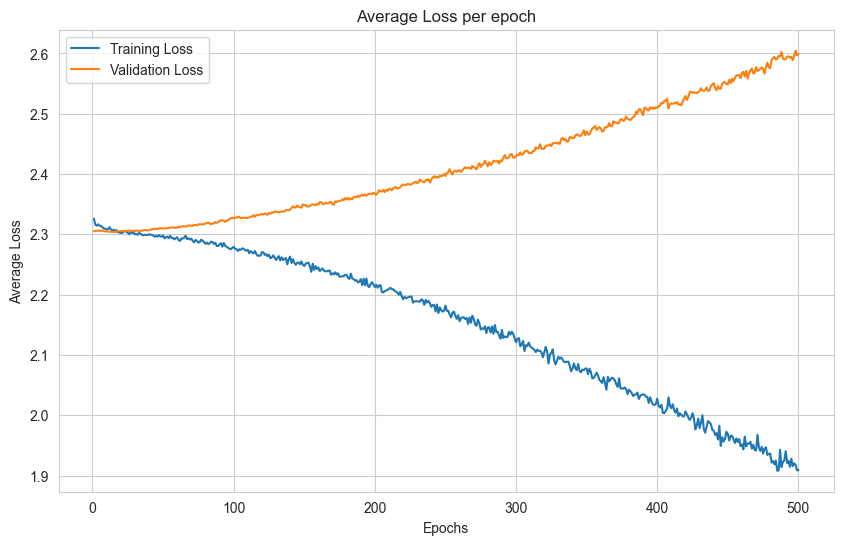

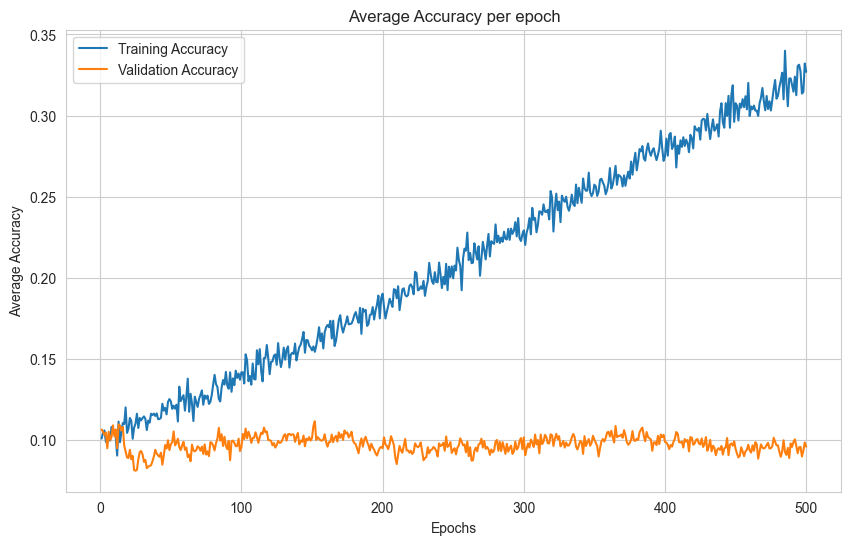

Overall Accuracy: 0.102


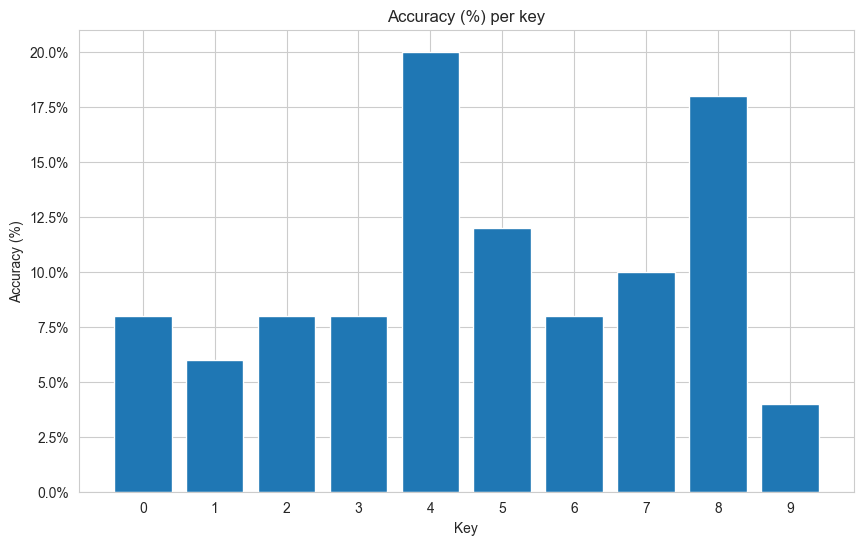

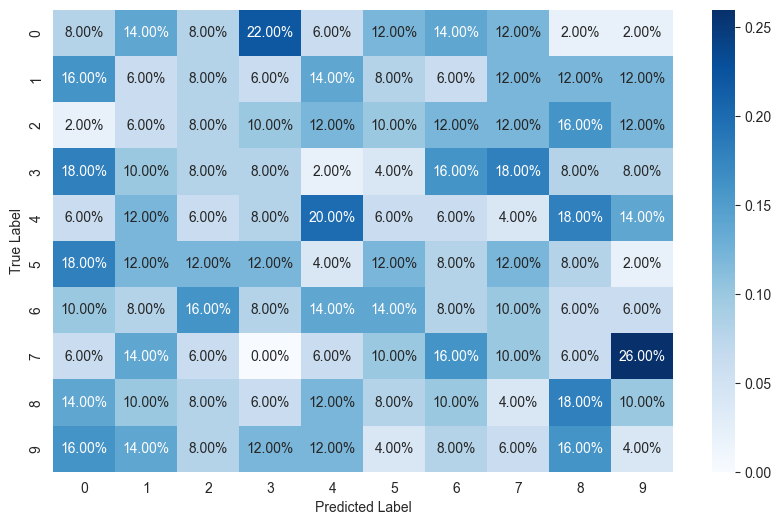

Accuracy for each key: 0: 8.0% 1: 6.0% 2: 8.0% 3: 8.0% 4: 20.0% 5: 12.0% 6: 8.0% 7: 10.0% 8: 18.0% 9: 4.0% 
              precision    recall  f1-score   support

           0       0.07      0.08      0.07        50
           1       0.06      0.06      0.06        50
           2       0.09      0.08      0.09        50
           3       0.09      0.08      0.08        50
           4       0.20      0.20      0.20        50
           5       0.14      0.12      0.13        50
           6       0.08      0.08      0.08        50
           7       0.10      0.10      0.10        50
           8       0.16      0.18      0.17        50
           9       0.04      0.04      0.04        50

    accuracy                           0.10       500
   macro avg       0.10      0.10      0.10       500
weighted avg       0.10      0.10      0.10       500

                    Model Parameters                    
Layer                    | Parameters
conv1d.weight            : 64 * 1 * 3 

In [32]:
def main():
    # setup parameters and load data
    batch_size = 64
    epochs = 500
    number_of_categories = 10
    
    X_train, X_val, X_test, y_train, y_val, y_test = importData()
    trainDataset = CSIDataset(X_train, y_train)
    valDataset = CSIDataset(X_val, y_val)
    
    trainLoader = DataLoader(trainDataset, shuffle=True, batch_size=batch_size)
    valLoader = DataLoader(valDataset, shuffle=True, batch_size=batch_size)

    lr = [0.001, 0.0001, 0.00001]
    model = CNN1D(number_of_categories)
    optimizer = optim.Adam(model.parameters(), lr=0.0001, weight_decay=0.0001)
    loss = nn.CrossEntropyLoss()
    # train_loss_list, train_acc_list, eval_loss_list, eval_acc_list = train_and_eval(model, epochs, optimizer, trainLoader, valLoader, loss, (X_train.shape[0]//batch_size) + 1)
    # plot_loss_accuracy(train_loss_list, train_acc_list, eval_loss_list, eval_acc_list, epochs)
    
    if (os.path.isfile("model_final.pth")):
        model.load_state_dict(torch.load('model_final.pth'))
    else:
        train_loss_list, train_acc_list, eval_loss_list, eval_acc_list = train_and_eval(model, epochs, optimizer, trainLoader, valLoader, loss, (X_train.shape[0]//batch_size) + 1)
        # save the model
        torch.save(model.state_dict(), 'model_final.pth')
        plot_loss_accuracy(train_loss_list, train_acc_list, eval_loss_list, eval_acc_list, epochs)
        
    # output = []
    # for i in range(len(lr)):
    #     model = CNN1D(number_of_categories)
    #     optimizer = optim.Adam(model.parameters(), lr=lr[i], weight_decay=0.0001)
    #     loss = nn.CrossEntropyLoss()
    #     train_loss_list, train_acc_list, eval_loss_list, eval_acc_list = train_and_eval(model, epochs, optimizer, trainLoader, valLoader, loss, (X_train.shape[0]//batch_size) + 1)
    #     output.append(eval_acc_list)
    #     
    # fig, acc = plt.subplots(figsize=(10,6))
    # x = [i for i in range(1, epochs+1)]
    # for i in range(len(output)):
    #     acc.plot(x, [trainAcc.item() for trainAcc in output[i]])
    # plt.legend()
    # plt.show()
    
    # plot_loss_accuracy(train_loss_list, train_acc_list, eval_loss_list, eval_acc_list, epochs)
    # torch.save(model.state_dict(), 'model_final.pth')
    
    # Simple check with test dataset
    model.eval()
    testDataset = CSIDataset(X_test, y_test)
    testLoader = DataLoader(testDataset, shuffle=True, batch_size=X_test.shape[0])
    test(model, testLoader, X_test.shape[0])
    
    print_model_parameters(model)
    
main()